##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 画像セグメンテーション

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation"> <img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/segmentation.ipynb"> <img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/segmentation.ipynb"> <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"> GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、修正した <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a> を使用した画像セグメンテーションのタスクに焦点を当てます。

## 画像セグメンテーションとは

画像分類タスクでは、ネットワークが各入力画像にラベル（またはクラス）を割り当てますが、そのオブジェクトの形状やどのピクセルがどのオブジェクトに属しているかなどを知りたい場合はどうすればよいでしょうか。この場合、画像のピクセルごとにクラスを割り当てる必要があります。このタスクはセグメンテーションとして知られています。セグメンテーションモデルは、画像に関してはるかに詳細な情報を返します。画像セグメンテーションには、医用イメージング、自動走行車、衛星撮像など、数多くの用途があります。

このチュートリアルでは [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)（Parkhi <em>et al</em>）を使用します。データセットには、37 種のペット品種と、品種当たり 200 枚の画像（train と test split で約 100 枚ずつ）が含まれます。それぞれの画像には対応するラベルとピクセル方向のマスクが含まれます。マスクは各ピクセルのクラスラベルです。各ピクセルには、次のいずれかのカテゴリが指定されます。

- クラス 1 : ペットに属するピクセル。
- クラス 2 : ペットと境界のピクセル。
- クラス 3: 上記のいずれにも該当しない、または周囲のピクセル。

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmpfs/tmp/pip-req-build-is38m_f5
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmpfs/tmp/pip-req-build-is38m_f5


  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42


  Preparing metadata (setup.py) ... -

 done


 \

 done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=f3bcb0f1a1ab12ed779bcec57dc4bc9dcbee107d7f53eabbfd506fd0cc2e319e
  Stored in directory: /tmpfs/tmp/pip-ephem-wheel-cache-4wsnzotz/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

import tensorflow_datasets as tfds

2024-01-11 22:13:08.059220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 22:13:08.059274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 22:13:08.060838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Oxford-IIIT ペットデータセットをダウンロードする

データセットは [TensorFlow Datasets から入手できます](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)。セグメンテーションマスクはバージョン 3 以上に含まれています。

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

また、画像の色値は `[0,1]` の範囲に正規化されています。最後に、上記で説明したとおり、セグメンテーションのマスクは {1, 2, 3} のいずれかでラベル付けされています。便宜上、セグメンテーションマスクから 1 を減算して、ラベルを {0, 1, 2} としましょう。

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

データセットにはすでに必要となる training と test split が含まれているため、そのまま同じ split を使用します。

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

次のクラスは、画像をランダムにフリップする単純な拡張を実行します。詳細は、[画像のデータ拡張](data_augmentation.ipynb)チュートリアルをご覧ください。


In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

入力パイプラインを構築し、入力をバッチ処理した後に拡張を適用します。

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

データセットの画像サンプルと対応するマスクを可視化しましょう。

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


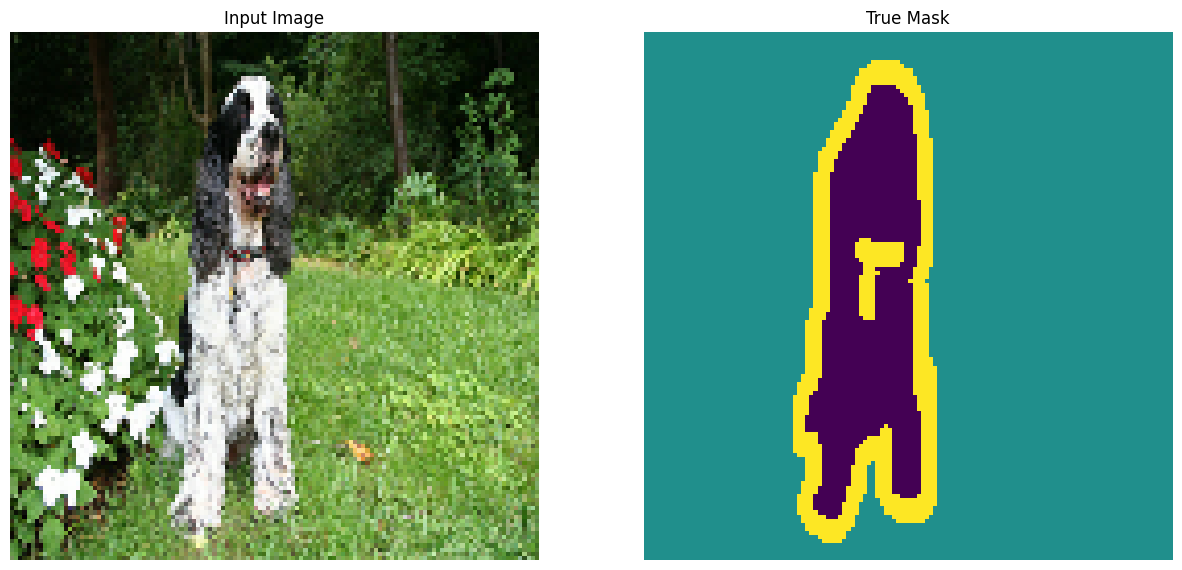

2024-01-11 22:13:16.387628: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


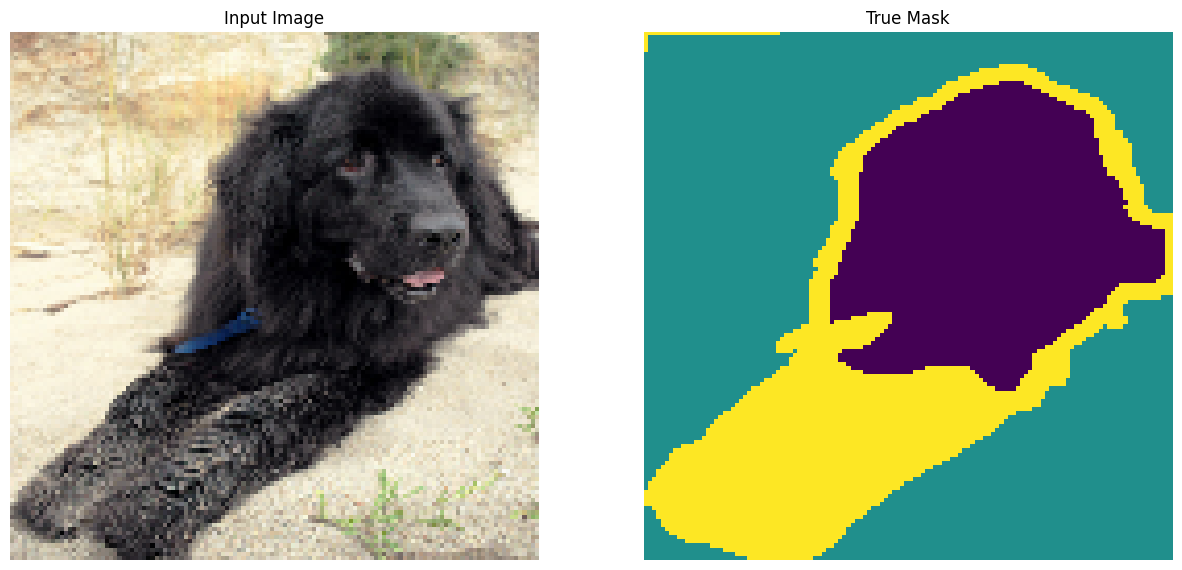

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## モデルを定義する

ここで使用されるモデルは変更された [U-Net](https://arxiv.org/abs/1505.04597) です。U-Net には、エンコーダ（ダウンサンプラー）とデコーダ（アップサンプラー）が含まれます。強力な特徴量を理解してトレーニング可能なパラメータ数を減らすため、[MobileNetV2](https://arxiv.org/abs/1801.04381) というトレーニング済みモデルをエンコーダとして使用します。デコーダについてはアップサンプルブロックを使用しますが、これは TensorFlow Examples リポジトリの [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) の例に実装済みです。（ノートブックの [pix2pix: 条件付き GAN を使用して画像から画像に変換する](../generative/pix2pix.ipynb)チュートリアルをご覧ください。）


前述のとおり、エンコーダは事前トレーニング済みの MobileNetV2 モデルです。`tf.keras.applications` からそのモデルを使用します。エンコーダはモデル内の中間レイヤーからの特定の出力で構成されています。トレーニングプロセス中にエンコーダはトレーニングされないので注意してください。

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

   8192/9406464 [..............................] - ETA: 0s

9406464/9406464 [==============================] - 0s 0us/step


デコーダおよびアップサンプラは、単に TensorFlow の 例に実装されている一連のアップサンプラブロックに過ぎません。

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

最後のレイヤーのフィルタ数は `output_channels` の数に設定されています。これはクラス当たり 1 つの出力チャンネルとなります。

## モデルをトレーニングする

では、後は、モデルををコンパイルしてトレーニングするだけです。

これはマルチクラスの分類問題であり、ラベルがクラスごとのピクセルのスコアのベクトルではなくスカラー整数であるため、`tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を使用して、`from_logits` を `True` に設定します。

推論を実行すると、ピクセルに割り当てられたラベルが最も高い値を持つチャンネルです。これは、`create_mask` 関数の作用です。

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

結果のモデルアーキテクチャをプロットしてみましょう。

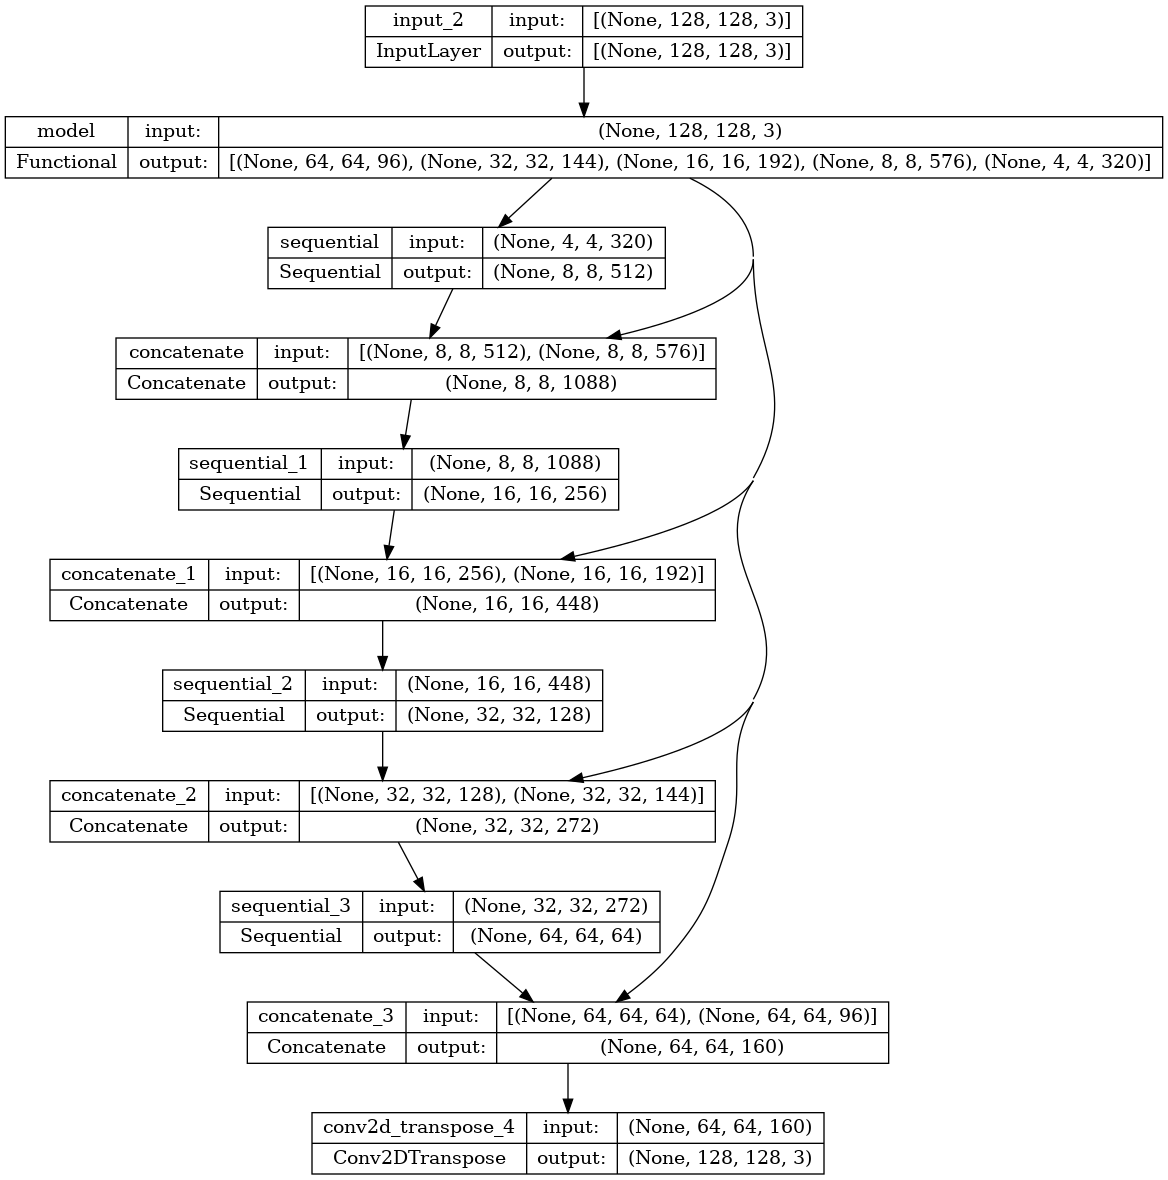

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

トレーニングする前に、モデルが何を予測するかを試してみましょう。

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 3s 3s/step


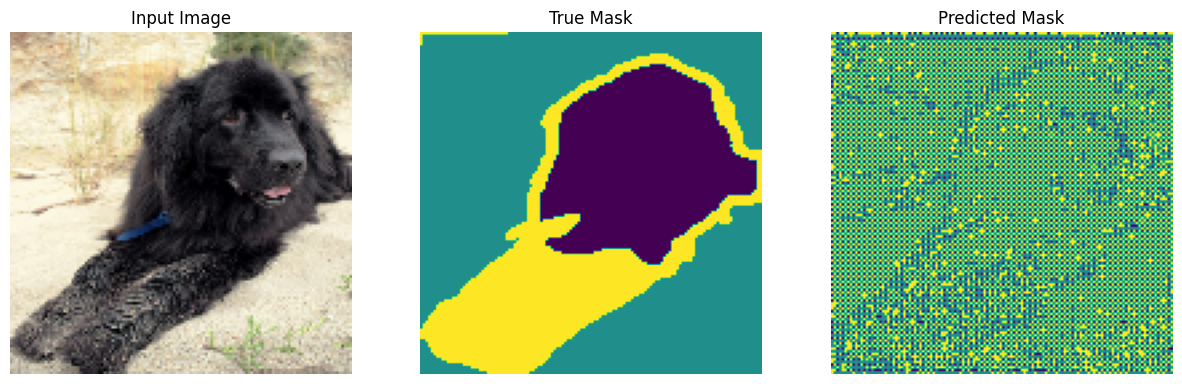

In [21]:
show_predictions()

以下に定義されるコールバックは、トレーニング中にモデルがどのように改善するかを観測するために使用されます。

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 47ms/step


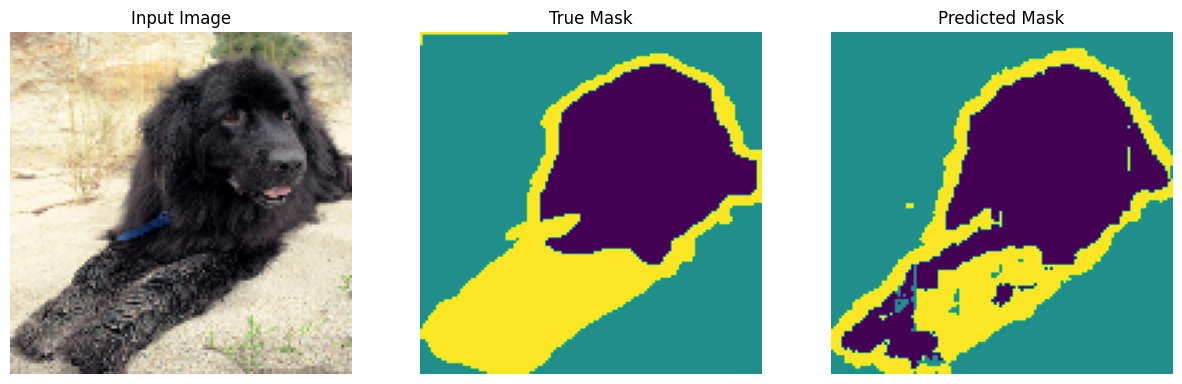


Sample Prediction after epoch 20

57/57 [==============================] - 8s 140ms/step - loss: 0.1712 - accuracy: 0.9302 - val_loss: 0.2666 - val_accuracy: 0.9043


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

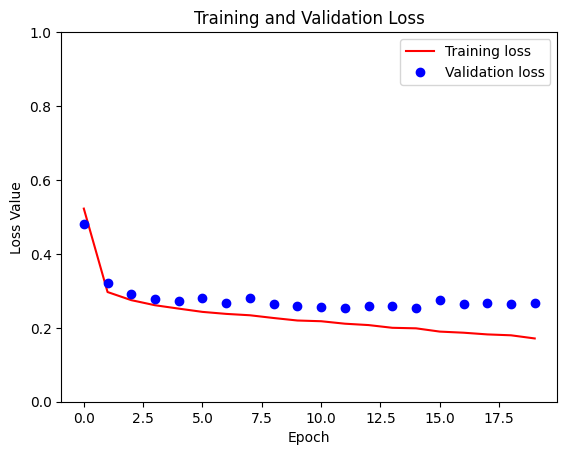

In [24]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## 予測する

いくつか予測を行ってみましょう。時間の節約重視の場合はエポック数を少なくしますが、高精度の結果重視の場合はエポック数を増やして設定します。

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 26ms/step


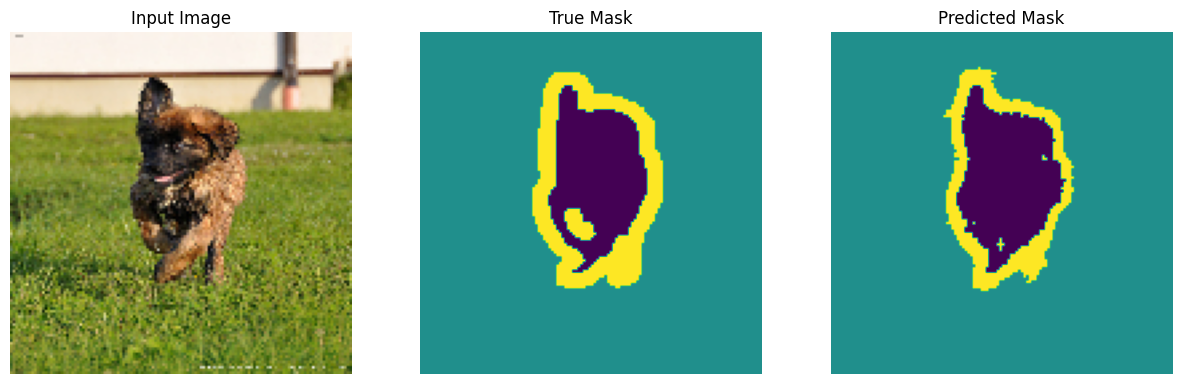

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 34ms/step


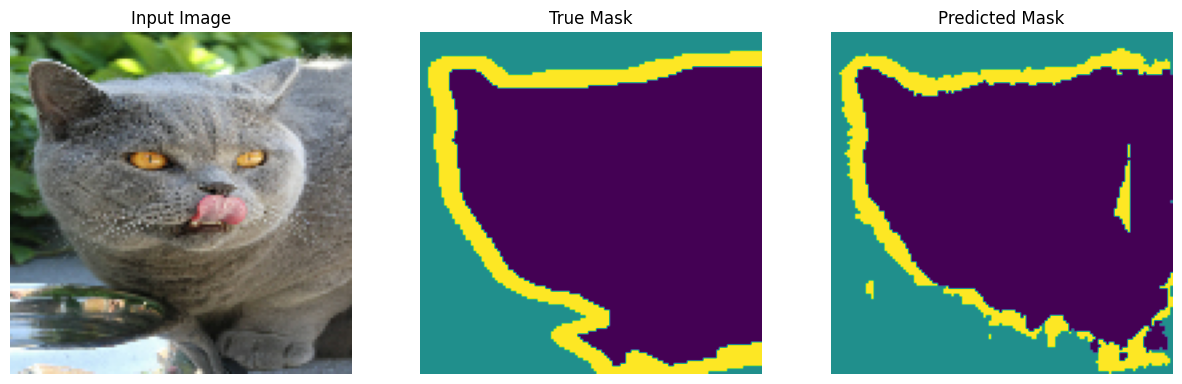

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 37ms/step


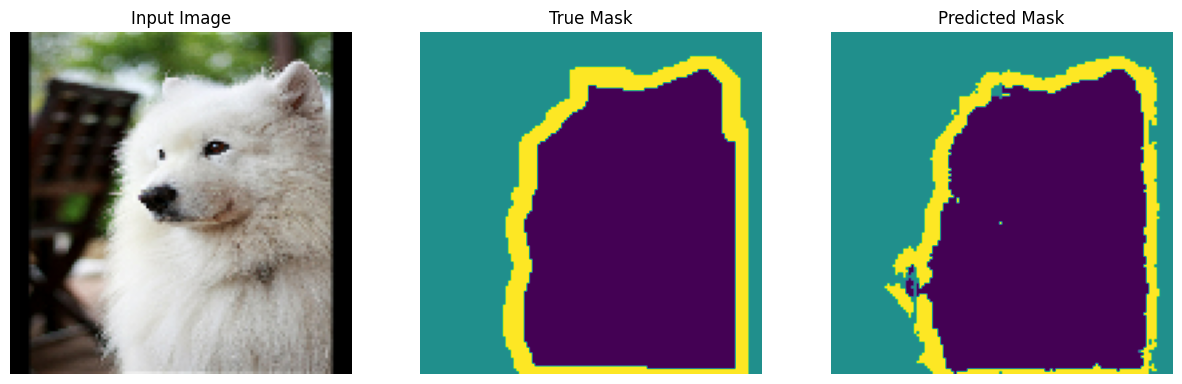

In [25]:
show_predictions(test_batches, 3)

## オプション: 不均衡なクラスとクラスの重み

セマンティックセグメンテーションデータセットは非常に不均衡であり、特定のクラスピクセルが他のクラスに比べて画像の内側寄りに存在する可能性があります。セグメンテーションの問題はピクセル単位の分類問題として対応することができるため、不均衡性を考慮して損失関数を重み付けすることで、不均衡の問題に対処することができます。単純かつエレガントにこの問題に取り組むことができます。詳細は、[不均衡なデータでの分類](../structured_data/imbalanced_data.ipynb)のチュートリアルをご覧ください。

[あいまいさを回避](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748)するために、`Model.fit` は 3 次元以上のターゲットの `class_weight` 引数をサポートしていません。

In [26]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20


 1/57 [..............................] - ETA: 1:37 - loss: 0.2137 - accuracy: 0.9390

 2/57 [>.............................] - ETA: 6s - loss: 0.2231 - accuracy: 0.9356  

 3/57 [>.............................] - ETA: 6s - loss: 0.2274 - accuracy: 0.9326

 4/57 [=>............................] - ETA: 5s - loss: 0.2286 - accuracy: 0.9309

 5/57 [=>............................] - ETA: 5s - loss: 0.2299 - accuracy: 0.9294

 6/57 [==>...........................] - ETA: 5s - loss: 0.2328 - accuracy: 0.9284

 7/57 [==>...........................] - ETA: 5s - loss: 0.2369 - accuracy: 0.9278

 8/57 [===>..........................] - ETA: 5s - loss: 0.2392 - accuracy: 0.9274

 9/57 [===>..........................] - ETA: 5s - loss: 0.2404 - accuracy: 0.9271

10/57 [====>.........................] - ETA: 5s - loss: 0.2395 - accuracy: 0.9274

11/57 [====>.........................] - ETA: 5s - loss: 0.2434 - accuracy: 0.9260

12/57 [=====>........................] - ETA: 5s - loss: 0.2427 - accuracy: 0.9261

13/57 [=====>........................] - ETA: 4s - loss: 0.2435 - accuracy: 0.9258

14/57 [======>.......................] - ETA: 4s - loss: 0.2434 - accuracy: 0.9260

15/57 [======>.......................] - ETA: 4s - loss: 0.2432 - accuracy: 0.9262

16/57 [=======>......................] - ETA: 4s - loss: 0.2452 - accuracy: 0.9257

17/57 [=======>......................] - ETA: 4s - loss: 0.2460 - accuracy: 0.9254

18/57 [========>.....................] - ETA: 4s - loss: 0.2458 - accuracy: 0.9252

19/57 [=========>....................] - ETA: 4s - loss: 0.2457 - accuracy: 0.9251

20/57 [=========>....................] - ETA: 4s - loss: 0.2466 - accuracy: 0.9248

21/57 [==========>...................] - ETA: 4s - loss: 0.2475 - accuracy: 0.9245

22/57 [==========>...................] - ETA: 3s - loss: 0.2483 - accuracy: 0.9243

23/57 [===========>..................] - ETA: 3s - loss: 0.2494 - accuracy: 0.9242

24/57 [===========>..................] - ETA: 3s - loss: 0.2516 - accuracy: 0.9236

25/57 [============>.................] - ETA: 3s - loss: 0.2521 - accuracy: 0.9236

26/57 [============>.................] - ETA: 3s - loss: 0.2546 - accuracy: 0.9230

27/57 [=============>................] - ETA: 3s - loss: 0.2542 - accuracy: 0.9230

28/57 [=============>................] - ETA: 3s - loss: 0.2546 - accuracy: 0.9229

29/57 [==============>...............] - ETA: 3s - loss: 0.2550 - accuracy: 0.9228

30/57 [==============>...............] - ETA: 3s - loss: 0.2553 - accuracy: 0.9228

31/57 [===============>..............] - ETA: 2s - loss: 0.2555 - accuracy: 0.9230

32/57 [===============>..............] - ETA: 2s - loss: 0.2549 - accuracy: 0.9231

33/57 [================>.............] - ETA: 2s - loss: 0.2545 - accuracy: 0.9232

34/57 [================>.............] - ETA: 2s - loss: 0.2543 - accuracy: 0.9232

35/57 [=================>............] - ETA: 2s - loss: 0.2546 - accuracy: 0.9230

36/57 [=================>............] - ETA: 2s - loss: 0.2549 - accuracy: 0.9229

37/57 [==================>...........] - ETA: 2s - loss: 0.2552 - accuracy: 0.9229

38/57 [===================>..........] - ETA: 2s - loss: 0.2556 - accuracy: 0.9228

39/57 [===================>..........] - ETA: 2s - loss: 0.2564 - accuracy: 0.9227

40/57 [====================>.........] - ETA: 1s - loss: 0.2570 - accuracy: 0.9227

41/57 [====================>.........] - ETA: 1s - loss: 0.2569 - accuracy: 0.9226

42/57 [=====================>........] - ETA: 1s - loss: 0.2578 - accuracy: 0.9223

43/57 [=====================>........] - ETA: 1s - loss: 0.2579 - accuracy: 0.9222

44/57 [======================>.......] - ETA: 1s - loss: 0.2586 - accuracy: 0.9221

45/57 [======================>.......] - ETA: 1s - loss: 0.2587 - accuracy: 0.9222

46/57 [=======================>......] - ETA: 1s - loss: 0.2589 - accuracy: 0.9221

47/57 [=======================>......] - ETA: 1s - loss: 0.2588 - accuracy: 0.9222

48/57 [========================>.....] - ETA: 1s - loss: 0.2587 - accuracy: 0.9222

49/57 [========================>.....] - ETA: 0s - loss: 0.2590 - accuracy: 0.9221

50/57 [=========================>....] - ETA: 0s - loss: 0.2589 - accuracy: 0.9219

51/57 [=========================>....] - ETA: 0s - loss: 0.2588 - accuracy: 0.9220

52/57 [==========================>...] - ETA: 0s - loss: 0.2594 - accuracy: 0.9218

53/57 [==========================>...] - ETA: 0s - loss: 0.2597 - accuracy: 0.9219

54/57 [===========================>..] - ETA: 0s - loss: 0.2597 - accuracy: 0.9220

55/57 [===========================>..] - ETA: 0s - loss: 0.2600 - accuracy: 0.9218

56/57 [============================>.] - ETA: 0s - loss: 0.2600 - accuracy: 0.9218

57/57 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9219

57/57 [==============================] - 8s 113ms/step - loss: 0.2599 - accuracy: 0.9219


Epoch 2/20


 1/57 [..............................] - ETA: 3s - loss: 0.2470 - accuracy: 0.9223

 2/57 [>.............................] - ETA: 6s - loss: 0.2507 - accuracy: 0.9206

 3/57 [>.............................] - ETA: 6s - loss: 0.2613 - accuracy: 0.9190

 4/57 [=>............................] - ETA: 5s - loss: 0.2627 - accuracy: 0.9190

 5/57 [=>............................] - ETA: 5s - loss: 0.2600 - accuracy: 0.9206

 6/57 [==>...........................] - ETA: 5s - loss: 0.2606 - accuracy: 0.9207

 7/57 [==>...........................] - ETA: 5s - loss: 0.2600 - accuracy: 0.9211

 8/57 [===>..........................] - ETA: 5s - loss: 0.2612 - accuracy: 0.9203

 9/57 [===>..........................] - ETA: 5s - loss: 0.2573 - accuracy: 0.9217

10/57 [====>.........................] - ETA: 5s - loss: 0.2603 - accuracy: 0.9208

11/57 [====>.........................] - ETA: 5s - loss: 0.2629 - accuracy: 0.9203

12/57 [=====>........................] - ETA: 5s - loss: 0.2608 - accuracy: 0.9212

13/57 [=====>........................] - ETA: 5s - loss: 0.2613 - accuracy: 0.9214

14/57 [======>.......................] - ETA: 4s - loss: 0.2634 - accuracy: 0.9208

15/57 [======>.......................] - ETA: 4s - loss: 0.2625 - accuracy: 0.9210

16/57 [=======>......................] - ETA: 4s - loss: 0.2621 - accuracy: 0.9208

17/57 [=======>......................] - ETA: 4s - loss: 0.2629 - accuracy: 0.9205

18/57 [========>.....................] - ETA: 4s - loss: 0.2647 - accuracy: 0.9203

19/57 [=========>....................] - ETA: 4s - loss: 0.2631 - accuracy: 0.9208

20/57 [=========>....................] - ETA: 4s - loss: 0.2633 - accuracy: 0.9207

21/57 [==========>...................] - ETA: 4s - loss: 0.2650 - accuracy: 0.9204

22/57 [==========>...................] - ETA: 3s - loss: 0.2645 - accuracy: 0.9205

23/57 [===========>..................] - ETA: 3s - loss: 0.2664 - accuracy: 0.9198

24/57 [===========>..................] - ETA: 3s - loss: 0.2678 - accuracy: 0.9194

25/57 [============>.................] - ETA: 3s - loss: 0.2677 - accuracy: 0.9196

26/57 [============>.................] - ETA: 3s - loss: 0.2675 - accuracy: 0.9197

27/57 [=============>................] - ETA: 3s - loss: 0.2673 - accuracy: 0.9198

28/57 [=============>................] - ETA: 3s - loss: 0.2671 - accuracy: 0.9198

29/57 [==============>...............] - ETA: 3s - loss: 0.2661 - accuracy: 0.9201

30/57 [==============>...............] - ETA: 3s - loss: 0.2668 - accuracy: 0.9196

31/57 [===============>..............] - ETA: 2s - loss: 0.2663 - accuracy: 0.9199

32/57 [===============>..............] - ETA: 2s - loss: 0.2671 - accuracy: 0.9197

33/57 [================>.............] - ETA: 2s - loss: 0.2668 - accuracy: 0.9198

34/57 [================>.............] - ETA: 2s - loss: 0.2671 - accuracy: 0.9197

35/57 [=================>............] - ETA: 2s - loss: 0.2667 - accuracy: 0.9199

36/57 [=================>............] - ETA: 2s - loss: 0.2661 - accuracy: 0.9200

37/57 [==================>...........] - ETA: 2s - loss: 0.2655 - accuracy: 0.9202

38/57 [===================>..........] - ETA: 2s - loss: 0.2658 - accuracy: 0.9201

39/57 [===================>..........] - ETA: 2s - loss: 0.2652 - accuracy: 0.9202

40/57 [====================>.........] - ETA: 1s - loss: 0.2646 - accuracy: 0.9204

41/57 [====================>.........] - ETA: 1s - loss: 0.2637 - accuracy: 0.9206

42/57 [=====================>........] - ETA: 1s - loss: 0.2636 - accuracy: 0.9206

43/57 [=====================>........] - ETA: 1s - loss: 0.2643 - accuracy: 0.9205

44/57 [======================>.......] - ETA: 1s - loss: 0.2641 - accuracy: 0.9206

45/57 [======================>.......] - ETA: 1s - loss: 0.2639 - accuracy: 0.9206

46/57 [=======================>......] - ETA: 1s - loss: 0.2637 - accuracy: 0.9208

47/57 [=======================>......] - ETA: 1s - loss: 0.2642 - accuracy: 0.9206

48/57 [========================>.....] - ETA: 1s - loss: 0.2640 - accuracy: 0.9206

49/57 [========================>.....] - ETA: 0s - loss: 0.2641 - accuracy: 0.9206

50/57 [=========================>....] - ETA: 0s - loss: 0.2639 - accuracy: 0.9207

51/57 [=========================>....] - ETA: 0s - loss: 0.2637 - accuracy: 0.9208

52/57 [==========================>...] - ETA: 0s - loss: 0.2633 - accuracy: 0.9208

53/57 [==========================>...] - ETA: 0s - loss: 0.2634 - accuracy: 0.9207

54/57 [===========================>..] - ETA: 0s - loss: 0.2635 - accuracy: 0.9207

55/57 [===========================>..] - ETA: 0s - loss: 0.2634 - accuracy: 0.9208

56/57 [============================>.] - ETA: 0s - loss: 0.2633 - accuracy: 0.9207

57/57 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.9209

57/57 [==============================] - 6s 115ms/step - loss: 0.2628 - accuracy: 0.9209


Epoch 3/20


 1/57 [..............................] - ETA: 6s - loss: 0.2541 - accuracy: 0.9218

 2/57 [>.............................] - ETA: 3s - loss: 0.2418 - accuracy: 0.9262

 3/57 [>.............................] - ETA: 4s - loss: 0.2469 - accuracy: 0.9235

 4/57 [=>............................] - ETA: 5s - loss: 0.2461 - accuracy: 0.9229

 5/57 [=>............................] - ETA: 5s - loss: 0.2477 - accuracy: 0.9229

 6/57 [==>...........................] - ETA: 5s - loss: 0.2435 - accuracy: 0.9240

 7/57 [==>...........................] - ETA: 5s - loss: 0.2470 - accuracy: 0.9240

 8/57 [===>..........................] - ETA: 5s - loss: 0.2480 - accuracy: 0.9238

 9/57 [===>..........................] - ETA: 5s - loss: 0.2489 - accuracy: 0.9234

10/57 [====>.........................] - ETA: 5s - loss: 0.2496 - accuracy: 0.9229

11/57 [====>.........................] - ETA: 5s - loss: 0.2486 - accuracy: 0.9233

12/57 [=====>........................] - ETA: 5s - loss: 0.2469 - accuracy: 0.9237

13/57 [=====>........................] - ETA: 4s - loss: 0.2449 - accuracy: 0.9243

14/57 [======>.......................] - ETA: 4s - loss: 0.2435 - accuracy: 0.9250

15/57 [======>.......................] - ETA: 4s - loss: 0.2437 - accuracy: 0.9252

16/57 [=======>......................] - ETA: 4s - loss: 0.2417 - accuracy: 0.9258

17/57 [=======>......................] - ETA: 4s - loss: 0.2420 - accuracy: 0.9257

18/57 [========>.....................] - ETA: 4s - loss: 0.2416 - accuracy: 0.9258

19/57 [=========>....................] - ETA: 4s - loss: 0.2419 - accuracy: 0.9256

20/57 [=========>....................] - ETA: 4s - loss: 0.2421 - accuracy: 0.9255

21/57 [==========>...................] - ETA: 4s - loss: 0.2426 - accuracy: 0.9254

22/57 [==========>...................] - ETA: 3s - loss: 0.2425 - accuracy: 0.9255

23/57 [===========>..................] - ETA: 3s - loss: 0.2422 - accuracy: 0.9257

24/57 [===========>..................] - ETA: 3s - loss: 0.2425 - accuracy: 0.9256

25/57 [============>.................] - ETA: 3s - loss: 0.2422 - accuracy: 0.9256

26/57 [============>.................] - ETA: 3s - loss: 0.2422 - accuracy: 0.9256

27/57 [=============>................] - ETA: 3s - loss: 0.2433 - accuracy: 0.9253

28/57 [=============>................] - ETA: 3s - loss: 0.2428 - accuracy: 0.9256

29/57 [==============>...............] - ETA: 3s - loss: 0.2433 - accuracy: 0.9255

30/57 [==============>...............] - ETA: 3s - loss: 0.2428 - accuracy: 0.9256

31/57 [===============>..............] - ETA: 2s - loss: 0.2422 - accuracy: 0.9258

32/57 [===============>..............] - ETA: 2s - loss: 0.2421 - accuracy: 0.9259

33/57 [================>.............] - ETA: 2s - loss: 0.2429 - accuracy: 0.9256

34/57 [================>.............] - ETA: 2s - loss: 0.2423 - accuracy: 0.9257

35/57 [=================>............] - ETA: 2s - loss: 0.2418 - accuracy: 0.9258

36/57 [=================>............] - ETA: 2s - loss: 0.2412 - accuracy: 0.9260

37/57 [==================>...........] - ETA: 2s - loss: 0.2407 - accuracy: 0.9262

38/57 [===================>..........] - ETA: 2s - loss: 0.2403 - accuracy: 0.9263

39/57 [===================>..........] - ETA: 2s - loss: 0.2397 - accuracy: 0.9264

40/57 [====================>.........] - ETA: 1s - loss: 0.2398 - accuracy: 0.9264

41/57 [====================>.........] - ETA: 1s - loss: 0.2399 - accuracy: 0.9263

42/57 [=====================>........] - ETA: 1s - loss: 0.2396 - accuracy: 0.9264

43/57 [=====================>........] - ETA: 1s - loss: 0.2392 - accuracy: 0.9265

44/57 [======================>.......] - ETA: 1s - loss: 0.2393 - accuracy: 0.9265

45/57 [======================>.......] - ETA: 1s - loss: 0.2395 - accuracy: 0.9265

46/57 [=======================>......] - ETA: 1s - loss: 0.2395 - accuracy: 0.9265

47/57 [=======================>......] - ETA: 1s - loss: 0.2391 - accuracy: 0.9266

48/57 [========================>.....] - ETA: 1s - loss: 0.2390 - accuracy: 0.9267

49/57 [========================>.....] - ETA: 0s - loss: 0.2395 - accuracy: 0.9265

50/57 [=========================>....] - ETA: 0s - loss: 0.2397 - accuracy: 0.9265

51/57 [=========================>....] - ETA: 0s - loss: 0.2398 - accuracy: 0.9264

52/57 [==========================>...] - ETA: 0s - loss: 0.2402 - accuracy: 0.9263

53/57 [==========================>...] - ETA: 0s - loss: 0.2405 - accuracy: 0.9262

54/57 [===========================>..] - ETA: 0s - loss: 0.2412 - accuracy: 0.9260

55/57 [===========================>..] - ETA: 0s - loss: 0.2414 - accuracy: 0.9260

56/57 [============================>.] - ETA: 0s - loss: 0.2418 - accuracy: 0.9259

57/57 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9260

57/57 [==============================] - 7s 116ms/step - loss: 0.2417 - accuracy: 0.9260


Epoch 4/20


 1/57 [..............................] - ETA: 6s - loss: 0.2668 - accuracy: 0.9142

 2/57 [>.............................] - ETA: 6s - loss: 0.2599 - accuracy: 0.9193

 3/57 [>.............................] - ETA: 4s - loss: 0.2594 - accuracy: 0.9193

 4/57 [=>............................] - ETA: 5s - loss: 0.2556 - accuracy: 0.9208

 5/57 [=>............................] - ETA: 5s - loss: 0.2560 - accuracy: 0.9207

 6/57 [==>...........................] - ETA: 5s - loss: 0.2614 - accuracy: 0.9203

 7/57 [==>...........................] - ETA: 5s - loss: 0.2567 - accuracy: 0.9221

 8/57 [===>..........................] - ETA: 5s - loss: 0.2541 - accuracy: 0.9228

 9/57 [===>..........................] - ETA: 5s - loss: 0.2561 - accuracy: 0.9221

10/57 [====>.........................] - ETA: 5s - loss: 0.2562 - accuracy: 0.9221

11/57 [====>.........................] - ETA: 5s - loss: 0.2524 - accuracy: 0.9230

12/57 [=====>........................] - ETA: 5s - loss: 0.2516 - accuracy: 0.9226

13/57 [=====>........................] - ETA: 5s - loss: 0.2522 - accuracy: 0.9231

14/57 [======>.......................] - ETA: 4s - loss: 0.2510 - accuracy: 0.9236

15/57 [======>.......................] - ETA: 4s - loss: 0.2528 - accuracy: 0.9234

16/57 [=======>......................] - ETA: 4s - loss: 0.2520 - accuracy: 0.9235

17/57 [=======>......................] - ETA: 4s - loss: 0.2511 - accuracy: 0.9237

18/57 [========>.....................] - ETA: 4s - loss: 0.2505 - accuracy: 0.9237

19/57 [=========>....................] - ETA: 4s - loss: 0.2489 - accuracy: 0.9241

20/57 [=========>....................] - ETA: 4s - loss: 0.2480 - accuracy: 0.9243

21/57 [==========>...................] - ETA: 4s - loss: 0.2474 - accuracy: 0.9246

22/57 [==========>...................] - ETA: 4s - loss: 0.2490 - accuracy: 0.9243

23/57 [===========>..................] - ETA: 3s - loss: 0.2484 - accuracy: 0.9244

24/57 [===========>..................] - ETA: 3s - loss: 0.2482 - accuracy: 0.9246

25/57 [============>.................] - ETA: 3s - loss: 0.2477 - accuracy: 0.9245

26/57 [============>.................] - ETA: 3s - loss: 0.2478 - accuracy: 0.9243

27/57 [=============>................] - ETA: 3s - loss: 0.2472 - accuracy: 0.9245

28/57 [=============>................] - ETA: 3s - loss: 0.2472 - accuracy: 0.9245

29/57 [==============>...............] - ETA: 3s - loss: 0.2469 - accuracy: 0.9246

30/57 [==============>...............] - ETA: 3s - loss: 0.2467 - accuracy: 0.9248

31/57 [===============>..............] - ETA: 3s - loss: 0.2462 - accuracy: 0.9249

32/57 [===============>..............] - ETA: 2s - loss: 0.2459 - accuracy: 0.9249

33/57 [================>.............] - ETA: 2s - loss: 0.2451 - accuracy: 0.9251

34/57 [================>.............] - ETA: 2s - loss: 0.2448 - accuracy: 0.9251

35/57 [=================>............] - ETA: 2s - loss: 0.2444 - accuracy: 0.9252

36/57 [=================>............] - ETA: 2s - loss: 0.2443 - accuracy: 0.9253

37/57 [==================>...........] - ETA: 2s - loss: 0.2439 - accuracy: 0.9255

38/57 [===================>..........] - ETA: 2s - loss: 0.2435 - accuracy: 0.9256

39/57 [===================>..........] - ETA: 2s - loss: 0.2434 - accuracy: 0.9256

40/57 [====================>.........] - ETA: 1s - loss: 0.2433 - accuracy: 0.9255

41/57 [====================>.........] - ETA: 1s - loss: 0.2430 - accuracy: 0.9255

42/57 [=====================>........] - ETA: 1s - loss: 0.2429 - accuracy: 0.9256

43/57 [=====================>........] - ETA: 1s - loss: 0.2427 - accuracy: 0.9258

44/57 [======================>.......] - ETA: 1s - loss: 0.2429 - accuracy: 0.9257

45/57 [======================>.......] - ETA: 1s - loss: 0.2427 - accuracy: 0.9257

46/57 [=======================>......] - ETA: 1s - loss: 0.2419 - accuracy: 0.9259

47/57 [=======================>......] - ETA: 1s - loss: 0.2418 - accuracy: 0.9260

48/57 [========================>.....] - ETA: 1s - loss: 0.2413 - accuracy: 0.9261

49/57 [========================>.....] - ETA: 0s - loss: 0.2412 - accuracy: 0.9261

50/57 [=========================>....] - ETA: 0s - loss: 0.2411 - accuracy: 0.9261

51/57 [=========================>....] - ETA: 0s - loss: 0.2408 - accuracy: 0.9263

52/57 [==========================>...] - ETA: 0s - loss: 0.2409 - accuracy: 0.9262

53/57 [==========================>...] - ETA: 0s - loss: 0.2407 - accuracy: 0.9262

54/57 [===========================>..] - ETA: 0s - loss: 0.2405 - accuracy: 0.9263

55/57 [===========================>..] - ETA: 0s - loss: 0.2398 - accuracy: 0.9264

56/57 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9265

57/57 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9265

57/57 [==============================] - 7s 117ms/step - loss: 0.2394 - accuracy: 0.9265


Epoch 5/20


 1/57 [..............................] - ETA: 6s - loss: 0.2404 - accuracy: 0.9261

 2/57 [>.............................] - ETA: 6s - loss: 0.2326 - accuracy: 0.9285

 3/57 [>.............................] - ETA: 6s - loss: 0.2344 - accuracy: 0.9276

 4/57 [=>............................] - ETA: 5s - loss: 0.2346 - accuracy: 0.9276

 5/57 [=>............................] - ETA: 5s - loss: 0.2351 - accuracy: 0.9270

 6/57 [==>...........................] - ETA: 5s - loss: 0.2319 - accuracy: 0.9279

 7/57 [==>...........................] - ETA: 5s - loss: 0.2311 - accuracy: 0.9278

 8/57 [===>..........................] - ETA: 5s - loss: 0.2287 - accuracy: 0.9283

 9/57 [===>..........................] - ETA: 5s - loss: 0.2271 - accuracy: 0.9290

10/57 [====>.........................] - ETA: 5s - loss: 0.2297 - accuracy: 0.9284

11/57 [====>.........................] - ETA: 5s - loss: 0.2282 - accuracy: 0.9290

12/57 [=====>........................] - ETA: 5s - loss: 0.2273 - accuracy: 0.9294

13/57 [=====>........................] - ETA: 4s - loss: 0.2257 - accuracy: 0.9298

14/57 [======>.......................] - ETA: 4s - loss: 0.2255 - accuracy: 0.9300

15/57 [======>.......................] - ETA: 4s - loss: 0.2264 - accuracy: 0.9298

16/57 [=======>......................] - ETA: 4s - loss: 0.2260 - accuracy: 0.9299

17/57 [=======>......................] - ETA: 4s - loss: 0.2251 - accuracy: 0.9302

18/57 [========>.....................] - ETA: 4s - loss: 0.2253 - accuracy: 0.9302

19/57 [=========>....................] - ETA: 4s - loss: 0.2242 - accuracy: 0.9305

20/57 [=========>....................] - ETA: 4s - loss: 0.2236 - accuracy: 0.9306

21/57 [==========>...................] - ETA: 4s - loss: 0.2228 - accuracy: 0.9308

22/57 [==========>...................] - ETA: 4s - loss: 0.2228 - accuracy: 0.9308

23/57 [===========>..................] - ETA: 3s - loss: 0.2231 - accuracy: 0.9307

24/57 [===========>..................] - ETA: 3s - loss: 0.2232 - accuracy: 0.9307

25/57 [============>.................] - ETA: 3s - loss: 0.2238 - accuracy: 0.9305

26/57 [============>.................] - ETA: 3s - loss: 0.2237 - accuracy: 0.9305

27/57 [=============>................] - ETA: 3s - loss: 0.2232 - accuracy: 0.9307

28/57 [=============>................] - ETA: 3s - loss: 0.2233 - accuracy: 0.9307

29/57 [==============>...............] - ETA: 3s - loss: 0.2235 - accuracy: 0.9307

30/57 [==============>...............] - ETA: 3s - loss: 0.2239 - accuracy: 0.9305

31/57 [===============>..............] - ETA: 2s - loss: 0.2236 - accuracy: 0.9306

32/57 [===============>..............] - ETA: 2s - loss: 0.2238 - accuracy: 0.9307

33/57 [================>.............] - ETA: 2s - loss: 0.2234 - accuracy: 0.9306

34/57 [================>.............] - ETA: 2s - loss: 0.2238 - accuracy: 0.9304

35/57 [=================>............] - ETA: 2s - loss: 0.2239 - accuracy: 0.9304

36/57 [=================>............] - ETA: 2s - loss: 0.2240 - accuracy: 0.9304

37/57 [==================>...........] - ETA: 2s - loss: 0.2240 - accuracy: 0.9305

38/57 [===================>..........] - ETA: 2s - loss: 0.2238 - accuracy: 0.9305

39/57 [===================>..........] - ETA: 2s - loss: 0.2238 - accuracy: 0.9305

40/57 [====================>.........] - ETA: 1s - loss: 0.2240 - accuracy: 0.9304

41/57 [====================>.........] - ETA: 1s - loss: 0.2237 - accuracy: 0.9305

42/57 [=====================>........] - ETA: 1s - loss: 0.2235 - accuracy: 0.9305

43/57 [=====================>........] - ETA: 1s - loss: 0.2233 - accuracy: 0.9306

44/57 [======================>.......] - ETA: 1s - loss: 0.2240 - accuracy: 0.9303

45/57 [======================>.......] - ETA: 1s - loss: 0.2237 - accuracy: 0.9304

46/57 [=======================>......] - ETA: 1s - loss: 0.2241 - accuracy: 0.9304

47/57 [=======================>......] - ETA: 1s - loss: 0.2245 - accuracy: 0.9304

48/57 [========================>.....] - ETA: 1s - loss: 0.2242 - accuracy: 0.9304

49/57 [========================>.....] - ETA: 0s - loss: 0.2240 - accuracy: 0.9305

50/57 [=========================>....] - ETA: 0s - loss: 0.2239 - accuracy: 0.9305

51/57 [=========================>....] - ETA: 0s - loss: 0.2238 - accuracy: 0.9304

52/57 [==========================>...] - ETA: 0s - loss: 0.2236 - accuracy: 0.9305

53/57 [==========================>...] - ETA: 0s - loss: 0.2236 - accuracy: 0.9305

54/57 [===========================>..] - ETA: 0s - loss: 0.2231 - accuracy: 0.9307

55/57 [===========================>..] - ETA: 0s - loss: 0.2231 - accuracy: 0.9307

56/57 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9306

57/57 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9304

57/57 [==============================] - 7s 116ms/step - loss: 0.2242 - accuracy: 0.9304


Epoch 6/20


 1/57 [..............................] - ETA: 6s - loss: 0.2319 - accuracy: 0.9267

 2/57 [>.............................] - ETA: 6s - loss: 0.2215 - accuracy: 0.9302

 3/57 [>.............................] - ETA: 6s - loss: 0.2268 - accuracy: 0.9296

 4/57 [=>............................] - ETA: 6s - loss: 0.2263 - accuracy: 0.9295

 5/57 [=>............................] - ETA: 5s - loss: 0.2281 - accuracy: 0.9289

 6/57 [==>...........................] - ETA: 5s - loss: 0.2271 - accuracy: 0.9298

 7/57 [==>...........................] - ETA: 5s - loss: 0.2247 - accuracy: 0.9303

 8/57 [===>..........................] - ETA: 5s - loss: 0.2225 - accuracy: 0.9309

 9/57 [===>..........................] - ETA: 5s - loss: 0.2233 - accuracy: 0.9300

10/57 [====>.........................] - ETA: 5s - loss: 0.2238 - accuracy: 0.9299

11/57 [====>.........................] - ETA: 5s - loss: 0.2235 - accuracy: 0.9303

12/57 [=====>........................] - ETA: 4s - loss: 0.2226 - accuracy: 0.9309

13/57 [=====>........................] - ETA: 4s - loss: 0.2207 - accuracy: 0.9317

14/57 [======>.......................] - ETA: 4s - loss: 0.2204 - accuracy: 0.9315

15/57 [======>.......................] - ETA: 4s - loss: 0.2203 - accuracy: 0.9314

16/57 [=======>......................] - ETA: 4s - loss: 0.2197 - accuracy: 0.9315

17/57 [=======>......................] - ETA: 4s - loss: 0.2203 - accuracy: 0.9312

18/57 [========>.....................] - ETA: 4s - loss: 0.2214 - accuracy: 0.9309

19/57 [=========>....................] - ETA: 4s - loss: 0.2211 - accuracy: 0.9311

20/57 [=========>....................] - ETA: 4s - loss: 0.2204 - accuracy: 0.9315

21/57 [==========>...................] - ETA: 4s - loss: 0.2214 - accuracy: 0.9312

22/57 [==========>...................] - ETA: 3s - loss: 0.2213 - accuracy: 0.9313

23/57 [===========>..................] - ETA: 3s - loss: 0.2216 - accuracy: 0.9311

24/57 [===========>..................] - ETA: 3s - loss: 0.2227 - accuracy: 0.9307

25/57 [============>.................] - ETA: 3s - loss: 0.2228 - accuracy: 0.9307

26/57 [============>.................] - ETA: 3s - loss: 0.2229 - accuracy: 0.9306

27/57 [=============>................] - ETA: 3s - loss: 0.2228 - accuracy: 0.9307

28/57 [=============>................] - ETA: 3s - loss: 0.2224 - accuracy: 0.9309

29/57 [==============>...............] - ETA: 3s - loss: 0.2228 - accuracy: 0.9308

30/57 [==============>...............] - ETA: 3s - loss: 0.2230 - accuracy: 0.9306

31/57 [===============>..............] - ETA: 2s - loss: 0.2220 - accuracy: 0.9309

32/57 [===============>..............] - ETA: 2s - loss: 0.2221 - accuracy: 0.9309

33/57 [================>.............] - ETA: 2s - loss: 0.2217 - accuracy: 0.9311

34/57 [================>.............] - ETA: 2s - loss: 0.2212 - accuracy: 0.9312

35/57 [=================>............] - ETA: 2s - loss: 0.2209 - accuracy: 0.9313

36/57 [=================>............] - ETA: 2s - loss: 0.2211 - accuracy: 0.9313

37/57 [==================>...........] - ETA: 2s - loss: 0.2210 - accuracy: 0.9313

38/57 [===================>..........] - ETA: 2s - loss: 0.2210 - accuracy: 0.9313

39/57 [===================>..........] - ETA: 2s - loss: 0.2210 - accuracy: 0.9313

40/57 [====================>.........] - ETA: 1s - loss: 0.2206 - accuracy: 0.9314

41/57 [====================>.........] - ETA: 1s - loss: 0.2202 - accuracy: 0.9315

42/57 [=====================>........] - ETA: 1s - loss: 0.2200 - accuracy: 0.9314

43/57 [=====================>........] - ETA: 1s - loss: 0.2208 - accuracy: 0.9312

44/57 [======================>.......] - ETA: 1s - loss: 0.2208 - accuracy: 0.9312

45/57 [======================>.......] - ETA: 1s - loss: 0.2206 - accuracy: 0.9313

46/57 [=======================>......] - ETA: 1s - loss: 0.2204 - accuracy: 0.9314

47/57 [=======================>......] - ETA: 1s - loss: 0.2204 - accuracy: 0.9314

48/57 [========================>.....] - ETA: 1s - loss: 0.2202 - accuracy: 0.9315

49/57 [========================>.....] - ETA: 0s - loss: 0.2203 - accuracy: 0.9314

50/57 [=========================>....] - ETA: 0s - loss: 0.2205 - accuracy: 0.9313

51/57 [=========================>....] - ETA: 0s - loss: 0.2200 - accuracy: 0.9314

52/57 [==========================>...] - ETA: 0s - loss: 0.2203 - accuracy: 0.9314

53/57 [==========================>...] - ETA: 0s - loss: 0.2203 - accuracy: 0.9314

54/57 [===========================>..] - ETA: 0s - loss: 0.2200 - accuracy: 0.9315

55/57 [===========================>..] - ETA: 0s - loss: 0.2201 - accuracy: 0.9314

56/57 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9314

57/57 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9316

57/57 [==============================] - 7s 114ms/step - loss: 0.2196 - accuracy: 0.9316


Epoch 7/20


 1/57 [..............................] - ETA: 6s - loss: 0.2140 - accuracy: 0.9354

 2/57 [>.............................] - ETA: 6s - loss: 0.2235 - accuracy: 0.9301

 3/57 [>.............................] - ETA: 6s - loss: 0.2155 - accuracy: 0.9330

 4/57 [=>............................] - ETA: 6s - loss: 0.2193 - accuracy: 0.9315

 5/57 [=>............................] - ETA: 6s - loss: 0.2191 - accuracy: 0.9313

 6/57 [==>...........................] - ETA: 5s - loss: 0.2204 - accuracy: 0.9310

 7/57 [==>...........................] - ETA: 5s - loss: 0.2190 - accuracy: 0.9318

 8/57 [===>..........................] - ETA: 5s - loss: 0.2195 - accuracy: 0.9315

 9/57 [===>..........................] - ETA: 5s - loss: 0.2174 - accuracy: 0.9322

10/57 [====>.........................] - ETA: 5s - loss: 0.2165 - accuracy: 0.9326

11/57 [====>.........................] - ETA: 5s - loss: 0.2171 - accuracy: 0.9321

12/57 [=====>........................] - ETA: 4s - loss: 0.2148 - accuracy: 0.9329

13/57 [=====>........................] - ETA: 4s - loss: 0.2154 - accuracy: 0.9325

14/57 [======>.......................] - ETA: 4s - loss: 0.2165 - accuracy: 0.9323

15/57 [======>.......................] - ETA: 4s - loss: 0.2179 - accuracy: 0.9319

16/57 [=======>......................] - ETA: 4s - loss: 0.2180 - accuracy: 0.9320

17/57 [=======>......................] - ETA: 4s - loss: 0.2172 - accuracy: 0.9323

18/57 [========>.....................] - ETA: 4s - loss: 0.2169 - accuracy: 0.9325

19/57 [=========>....................] - ETA: 4s - loss: 0.2171 - accuracy: 0.9324

20/57 [=========>....................] - ETA: 4s - loss: 0.2170 - accuracy: 0.9323

21/57 [==========>...................] - ETA: 4s - loss: 0.2168 - accuracy: 0.9324

22/57 [==========>...................] - ETA: 3s - loss: 0.2173 - accuracy: 0.9321

23/57 [===========>..................] - ETA: 3s - loss: 0.2170 - accuracy: 0.9321

24/57 [===========>..................] - ETA: 3s - loss: 0.2166 - accuracy: 0.9323

25/57 [============>.................] - ETA: 3s - loss: 0.2168 - accuracy: 0.9322

26/57 [============>.................] - ETA: 3s - loss: 0.2165 - accuracy: 0.9324

27/57 [=============>................] - ETA: 3s - loss: 0.2169 - accuracy: 0.9324

28/57 [=============>................] - ETA: 3s - loss: 0.2167 - accuracy: 0.9325

29/57 [==============>...............] - ETA: 3s - loss: 0.2167 - accuracy: 0.9324

30/57 [==============>...............] - ETA: 3s - loss: 0.2176 - accuracy: 0.9321

31/57 [===============>..............] - ETA: 2s - loss: 0.2172 - accuracy: 0.9322

32/57 [===============>..............] - ETA: 2s - loss: 0.2169 - accuracy: 0.9322

33/57 [================>.............] - ETA: 2s - loss: 0.2170 - accuracy: 0.9321

34/57 [================>.............] - ETA: 2s - loss: 0.2168 - accuracy: 0.9323

35/57 [=================>............] - ETA: 2s - loss: 0.2169 - accuracy: 0.9323

36/57 [=================>............] - ETA: 2s - loss: 0.2160 - accuracy: 0.9326

37/57 [==================>...........] - ETA: 2s - loss: 0.2162 - accuracy: 0.9325

38/57 [===================>..........] - ETA: 2s - loss: 0.2166 - accuracy: 0.9323

39/57 [===================>..........] - ETA: 2s - loss: 0.2162 - accuracy: 0.9324

40/57 [====================>.........] - ETA: 1s - loss: 0.2156 - accuracy: 0.9326

41/57 [====================>.........] - ETA: 1s - loss: 0.2153 - accuracy: 0.9327

42/57 [=====================>........] - ETA: 1s - loss: 0.2146 - accuracy: 0.9329

43/57 [=====================>........] - ETA: 1s - loss: 0.2146 - accuracy: 0.9329

44/57 [======================>.......] - ETA: 1s - loss: 0.2146 - accuracy: 0.9329

45/57 [======================>.......] - ETA: 1s - loss: 0.2145 - accuracy: 0.9330

46/57 [=======================>......] - ETA: 1s - loss: 0.2143 - accuracy: 0.9331

47/57 [=======================>......] - ETA: 1s - loss: 0.2142 - accuracy: 0.9330

48/57 [========================>.....] - ETA: 1s - loss: 0.2140 - accuracy: 0.9331

49/57 [========================>.....] - ETA: 0s - loss: 0.2137 - accuracy: 0.9331

50/57 [=========================>....] - ETA: 0s - loss: 0.2133 - accuracy: 0.9333

51/57 [=========================>....] - ETA: 0s - loss: 0.2131 - accuracy: 0.9333

52/57 [==========================>...] - ETA: 0s - loss: 0.2129 - accuracy: 0.9334

53/57 [==========================>...] - ETA: 0s - loss: 0.2130 - accuracy: 0.9333

54/57 [===========================>..] - ETA: 0s - loss: 0.2131 - accuracy: 0.9333

55/57 [===========================>..] - ETA: 0s - loss: 0.2131 - accuracy: 0.9332

56/57 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9333

57/57 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9334

57/57 [==============================] - 6s 114ms/step - loss: 0.2126 - accuracy: 0.9334


Epoch 8/20


 1/57 [..............................] - ETA: 6s - loss: 0.2013 - accuracy: 0.9388

 2/57 [>.............................] - ETA: 6s - loss: 0.2036 - accuracy: 0.9375

 3/57 [>.............................] - ETA: 6s - loss: 0.1997 - accuracy: 0.9379

 4/57 [=>............................] - ETA: 6s - loss: 0.2038 - accuracy: 0.9359

 5/57 [=>............................] - ETA: 5s - loss: 0.2036 - accuracy: 0.9357

 6/57 [==>...........................] - ETA: 5s - loss: 0.2044 - accuracy: 0.9354

 7/57 [==>...........................] - ETA: 5s - loss: 0.2047 - accuracy: 0.9351

 8/57 [===>..........................] - ETA: 5s - loss: 0.2055 - accuracy: 0.9348

 9/57 [===>..........................] - ETA: 5s - loss: 0.2056 - accuracy: 0.9348

10/57 [====>.........................] - ETA: 5s - loss: 0.2053 - accuracy: 0.9353

11/57 [====>.........................] - ETA: 5s - loss: 0.2059 - accuracy: 0.9352

12/57 [=====>........................] - ETA: 4s - loss: 0.2056 - accuracy: 0.9353

13/57 [=====>........................] - ETA: 4s - loss: 0.2059 - accuracy: 0.9351

14/57 [======>.......................] - ETA: 4s - loss: 0.2051 - accuracy: 0.9354

15/57 [======>.......................] - ETA: 4s - loss: 0.2041 - accuracy: 0.9357

16/57 [=======>......................] - ETA: 4s - loss: 0.2041 - accuracy: 0.9357

17/57 [=======>......................] - ETA: 4s - loss: 0.2048 - accuracy: 0.9357

18/57 [========>.....................] - ETA: 4s - loss: 0.2056 - accuracy: 0.9355

19/57 [=========>....................] - ETA: 4s - loss: 0.2054 - accuracy: 0.9354

20/57 [=========>....................] - ETA: 4s - loss: 0.2049 - accuracy: 0.9356

21/57 [==========>...................] - ETA: 4s - loss: 0.2039 - accuracy: 0.9359

22/57 [==========>...................] - ETA: 3s - loss: 0.2034 - accuracy: 0.9360

23/57 [===========>..................] - ETA: 3s - loss: 0.2033 - accuracy: 0.9359

24/57 [===========>..................] - ETA: 3s - loss: 0.2034 - accuracy: 0.9357

25/57 [============>.................] - ETA: 3s - loss: 0.2029 - accuracy: 0.9359

26/57 [============>.................] - ETA: 3s - loss: 0.2027 - accuracy: 0.9360

27/57 [=============>................] - ETA: 3s - loss: 0.2024 - accuracy: 0.9361

28/57 [=============>................] - ETA: 3s - loss: 0.2022 - accuracy: 0.9362

29/57 [==============>...............] - ETA: 3s - loss: 0.2022 - accuracy: 0.9362

30/57 [==============>...............] - ETA: 3s - loss: 0.2026 - accuracy: 0.9360

31/57 [===============>..............] - ETA: 2s - loss: 0.2026 - accuracy: 0.9361

32/57 [===============>..............] - ETA: 2s - loss: 0.2026 - accuracy: 0.9361

33/57 [================>.............] - ETA: 2s - loss: 0.2025 - accuracy: 0.9361

34/57 [================>.............] - ETA: 2s - loss: 0.2027 - accuracy: 0.9360

35/57 [=================>............] - ETA: 2s - loss: 0.2034 - accuracy: 0.9359

36/57 [=================>............] - ETA: 2s - loss: 0.2032 - accuracy: 0.9360

37/57 [==================>...........] - ETA: 2s - loss: 0.2031 - accuracy: 0.9360

38/57 [===================>..........] - ETA: 2s - loss: 0.2032 - accuracy: 0.9359

39/57 [===================>..........] - ETA: 2s - loss: 0.2035 - accuracy: 0.9358

40/57 [====================>.........] - ETA: 1s - loss: 0.2039 - accuracy: 0.9358

41/57 [====================>.........] - ETA: 1s - loss: 0.2037 - accuracy: 0.9359

42/57 [=====================>........] - ETA: 1s - loss: 0.2039 - accuracy: 0.9359

43/57 [=====================>........] - ETA: 1s - loss: 0.2035 - accuracy: 0.9360

44/57 [======================>.......] - ETA: 1s - loss: 0.2034 - accuracy: 0.9359

45/57 [======================>.......] - ETA: 1s - loss: 0.2031 - accuracy: 0.9360

46/57 [=======================>......] - ETA: 1s - loss: 0.2034 - accuracy: 0.9359

47/57 [=======================>......] - ETA: 1s - loss: 0.2033 - accuracy: 0.9359

48/57 [========================>.....] - ETA: 1s - loss: 0.2035 - accuracy: 0.9358

49/57 [========================>.....] - ETA: 0s - loss: 0.2035 - accuracy: 0.9359

50/57 [=========================>....] - ETA: 0s - loss: 0.2036 - accuracy: 0.9359

51/57 [=========================>....] - ETA: 0s - loss: 0.2036 - accuracy: 0.9359

52/57 [==========================>...] - ETA: 0s - loss: 0.2037 - accuracy: 0.9358

53/57 [==========================>...] - ETA: 0s - loss: 0.2038 - accuracy: 0.9358

54/57 [===========================>..] - ETA: 0s - loss: 0.2037 - accuracy: 0.9357

55/57 [===========================>..] - ETA: 0s - loss: 0.2039 - accuracy: 0.9357

56/57 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9357

57/57 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9358

57/57 [==============================] - 6s 113ms/step - loss: 0.2037 - accuracy: 0.9358


Epoch 9/20


 1/57 [..............................] - ETA: 6s - loss: 0.1917 - accuracy: 0.9421

 2/57 [>.............................] - ETA: 6s - loss: 0.2001 - accuracy: 0.9375

 3/57 [>.............................] - ETA: 6s - loss: 0.2015 - accuracy: 0.9358

 4/57 [=>............................] - ETA: 5s - loss: 0.2080 - accuracy: 0.9330

 5/57 [=>............................] - ETA: 5s - loss: 0.2078 - accuracy: 0.9335

 6/57 [==>...........................] - ETA: 5s - loss: 0.2085 - accuracy: 0.9333

 7/57 [==>...........................] - ETA: 5s - loss: 0.2085 - accuracy: 0.9336

 8/57 [===>..........................] - ETA: 5s - loss: 0.2070 - accuracy: 0.9343

 9/57 [===>..........................] - ETA: 5s - loss: 0.2050 - accuracy: 0.9348

10/57 [====>.........................] - ETA: 5s - loss: 0.2045 - accuracy: 0.9350

11/57 [====>.........................] - ETA: 4s - loss: 0.2032 - accuracy: 0.9354

12/57 [=====>........................] - ETA: 4s - loss: 0.2043 - accuracy: 0.9350

13/57 [=====>........................] - ETA: 4s - loss: 0.2038 - accuracy: 0.9353

14/57 [======>.......................] - ETA: 4s - loss: 0.2023 - accuracy: 0.9357

15/57 [======>.......................] - ETA: 4s - loss: 0.2006 - accuracy: 0.9363

16/57 [=======>......................] - ETA: 4s - loss: 0.2009 - accuracy: 0.9361

17/57 [=======>......................] - ETA: 4s - loss: 0.2006 - accuracy: 0.9362

18/57 [========>.....................] - ETA: 4s - loss: 0.1992 - accuracy: 0.9367

19/57 [=========>....................] - ETA: 4s - loss: 0.1987 - accuracy: 0.9368

20/57 [=========>....................] - ETA: 4s - loss: 0.1987 - accuracy: 0.9368

21/57 [==========>...................] - ETA: 3s - loss: 0.1984 - accuracy: 0.9369

22/57 [==========>...................] - ETA: 3s - loss: 0.1991 - accuracy: 0.9367

23/57 [===========>..................] - ETA: 3s - loss: 0.1988 - accuracy: 0.9368

24/57 [===========>..................] - ETA: 3s - loss: 0.1982 - accuracy: 0.9370

25/57 [============>.................] - ETA: 3s - loss: 0.1981 - accuracy: 0.9370

26/57 [============>.................] - ETA: 3s - loss: 0.1981 - accuracy: 0.9371

27/57 [=============>................] - ETA: 3s - loss: 0.1976 - accuracy: 0.9373

28/57 [=============>................] - ETA: 3s - loss: 0.1979 - accuracy: 0.9372

29/57 [==============>...............] - ETA: 3s - loss: 0.1983 - accuracy: 0.9372

30/57 [==============>...............] - ETA: 3s - loss: 0.1983 - accuracy: 0.9371

31/57 [===============>..............] - ETA: 2s - loss: 0.1983 - accuracy: 0.9370

32/57 [===============>..............] - ETA: 2s - loss: 0.1980 - accuracy: 0.9371

33/57 [================>.............] - ETA: 2s - loss: 0.1979 - accuracy: 0.9371

34/57 [================>.............] - ETA: 2s - loss: 0.1979 - accuracy: 0.9371

35/57 [=================>............] - ETA: 2s - loss: 0.1979 - accuracy: 0.9372

36/57 [=================>............] - ETA: 2s - loss: 0.1980 - accuracy: 0.9372

37/57 [==================>...........] - ETA: 2s - loss: 0.1974 - accuracy: 0.9373

38/57 [===================>..........] - ETA: 2s - loss: 0.1979 - accuracy: 0.9371

39/57 [===================>..........] - ETA: 2s - loss: 0.1982 - accuracy: 0.9371

40/57 [====================>.........] - ETA: 1s - loss: 0.1981 - accuracy: 0.9372

41/57 [====================>.........] - ETA: 1s - loss: 0.1978 - accuracy: 0.9373

42/57 [=====================>........] - ETA: 1s - loss: 0.1977 - accuracy: 0.9373

43/57 [=====================>........] - ETA: 1s - loss: 0.1976 - accuracy: 0.9373

44/57 [======================>.......] - ETA: 1s - loss: 0.1971 - accuracy: 0.9375

45/57 [======================>.......] - ETA: 1s - loss: 0.1968 - accuracy: 0.9376

46/57 [=======================>......] - ETA: 1s - loss: 0.1969 - accuracy: 0.9375

47/57 [=======================>......] - ETA: 1s - loss: 0.1968 - accuracy: 0.9375

48/57 [========================>.....] - ETA: 1s - loss: 0.1967 - accuracy: 0.9375

49/57 [========================>.....] - ETA: 0s - loss: 0.1965 - accuracy: 0.9376

50/57 [=========================>....] - ETA: 0s - loss: 0.1964 - accuracy: 0.9377

51/57 [=========================>....] - ETA: 0s - loss: 0.1961 - accuracy: 0.9378

52/57 [==========================>...] - ETA: 0s - loss: 0.1961 - accuracy: 0.9378

53/57 [==========================>...] - ETA: 0s - loss: 0.1960 - accuracy: 0.9378

54/57 [===========================>..] - ETA: 0s - loss: 0.1958 - accuracy: 0.9378

55/57 [===========================>..] - ETA: 0s - loss: 0.1960 - accuracy: 0.9377

56/57 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9377

57/57 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9377

57/57 [==============================] - 6s 112ms/step - loss: 0.1960 - accuracy: 0.9377


Epoch 10/20


 1/57 [..............................] - ETA: 6s - loss: 0.1996 - accuracy: 0.9378

 2/57 [>.............................] - ETA: 6s - loss: 0.1942 - accuracy: 0.9398

 3/57 [>.............................] - ETA: 6s - loss: 0.1929 - accuracy: 0.9397

 4/57 [=>............................] - ETA: 5s - loss: 0.1903 - accuracy: 0.9403

 5/57 [=>............................] - ETA: 5s - loss: 0.1916 - accuracy: 0.9390

 6/57 [==>...........................] - ETA: 5s - loss: 0.1927 - accuracy: 0.9384

 7/57 [==>...........................] - ETA: 5s - loss: 0.1947 - accuracy: 0.9379

 8/57 [===>..........................] - ETA: 5s - loss: 0.1950 - accuracy: 0.9379

 9/57 [===>..........................] - ETA: 5s - loss: 0.1946 - accuracy: 0.9381

10/57 [====>.........................] - ETA: 5s - loss: 0.1953 - accuracy: 0.9380

11/57 [====>.........................] - ETA: 4s - loss: 0.1939 - accuracy: 0.9385

12/57 [=====>........................] - ETA: 4s - loss: 0.1934 - accuracy: 0.9386

13/57 [=====>........................] - ETA: 4s - loss: 0.1926 - accuracy: 0.9388

14/57 [======>.......................] - ETA: 4s - loss: 0.1920 - accuracy: 0.9389

15/57 [======>.......................] - ETA: 4s - loss: 0.1935 - accuracy: 0.9384

16/57 [=======>......................] - ETA: 4s - loss: 0.1930 - accuracy: 0.9386

17/57 [=======>......................] - ETA: 4s - loss: 0.1923 - accuracy: 0.9389

18/57 [========>.....................] - ETA: 4s - loss: 0.1921 - accuracy: 0.9390

19/57 [=========>....................] - ETA: 4s - loss: 0.1923 - accuracy: 0.9389

20/57 [=========>....................] - ETA: 4s - loss: 0.1924 - accuracy: 0.9387

21/57 [==========>...................] - ETA: 3s - loss: 0.1931 - accuracy: 0.9384

22/57 [==========>...................] - ETA: 3s - loss: 0.1930 - accuracy: 0.9384

23/57 [===========>..................] - ETA: 3s - loss: 0.1927 - accuracy: 0.9387

24/57 [===========>..................] - ETA: 3s - loss: 0.1925 - accuracy: 0.9388

25/57 [============>.................] - ETA: 3s - loss: 0.1929 - accuracy: 0.9387

26/57 [============>.................] - ETA: 3s - loss: 0.1929 - accuracy: 0.9386

27/57 [=============>................] - ETA: 3s - loss: 0.1924 - accuracy: 0.9387

28/57 [=============>................] - ETA: 3s - loss: 0.1918 - accuracy: 0.9389

29/57 [==============>...............] - ETA: 3s - loss: 0.1919 - accuracy: 0.9389

30/57 [==============>...............] - ETA: 3s - loss: 0.1917 - accuracy: 0.9390

31/57 [===============>..............] - ETA: 2s - loss: 0.1916 - accuracy: 0.9390

32/57 [===============>..............] - ETA: 2s - loss: 0.1918 - accuracy: 0.9389

33/57 [================>.............] - ETA: 2s - loss: 0.1916 - accuracy: 0.9390

34/57 [================>.............] - ETA: 2s - loss: 0.1913 - accuracy: 0.9391

35/57 [=================>............] - ETA: 2s - loss: 0.1910 - accuracy: 0.9392

36/57 [=================>............] - ETA: 2s - loss: 0.1906 - accuracy: 0.9393

37/57 [==================>...........] - ETA: 2s - loss: 0.1905 - accuracy: 0.9393

38/57 [===================>..........] - ETA: 2s - loss: 0.1905 - accuracy: 0.9393

39/57 [===================>..........] - ETA: 2s - loss: 0.1906 - accuracy: 0.9393

40/57 [====================>.........] - ETA: 1s - loss: 0.1906 - accuracy: 0.9393

41/57 [====================>.........] - ETA: 1s - loss: 0.1909 - accuracy: 0.9392

42/57 [=====================>........] - ETA: 1s - loss: 0.1909 - accuracy: 0.9392

43/57 [=====================>........] - ETA: 1s - loss: 0.1907 - accuracy: 0.9392

44/57 [======================>.......] - ETA: 1s - loss: 0.1906 - accuracy: 0.9393

45/57 [======================>.......] - ETA: 1s - loss: 0.1906 - accuracy: 0.9392

46/57 [=======================>......] - ETA: 1s - loss: 0.1907 - accuracy: 0.9393

47/57 [=======================>......] - ETA: 1s - loss: 0.1908 - accuracy: 0.9393

48/57 [========================>.....] - ETA: 1s - loss: 0.1906 - accuracy: 0.9394

49/57 [========================>.....] - ETA: 0s - loss: 0.1908 - accuracy: 0.9393

50/57 [=========================>....] - ETA: 0s - loss: 0.1911 - accuracy: 0.9392

51/57 [=========================>....] - ETA: 0s - loss: 0.1911 - accuracy: 0.9392

52/57 [==========================>...] - ETA: 0s - loss: 0.1913 - accuracy: 0.9391

53/57 [==========================>...] - ETA: 0s - loss: 0.1914 - accuracy: 0.9391

54/57 [===========================>..] - ETA: 0s - loss: 0.1914 - accuracy: 0.9391

55/57 [===========================>..] - ETA: 0s - loss: 0.1913 - accuracy: 0.9392

56/57 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.9393

57/57 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9391

57/57 [==============================] - 6s 112ms/step - loss: 0.1914 - accuracy: 0.9391


Epoch 11/20


 1/57 [..............................] - ETA: 6s - loss: 0.2144 - accuracy: 0.9296

 2/57 [>.............................] - ETA: 6s - loss: 0.2037 - accuracy: 0.9327

 3/57 [>.............................] - ETA: 6s - loss: 0.1996 - accuracy: 0.9358

 4/57 [=>............................] - ETA: 5s - loss: 0.1971 - accuracy: 0.9376

 5/57 [=>............................] - ETA: 5s - loss: 0.1957 - accuracy: 0.9377

 6/57 [==>...........................] - ETA: 5s - loss: 0.1941 - accuracy: 0.9384

 7/57 [==>...........................] - ETA: 5s - loss: 0.1965 - accuracy: 0.9377

 8/57 [===>..........................] - ETA: 5s - loss: 0.1962 - accuracy: 0.9377

 9/57 [===>..........................] - ETA: 5s - loss: 0.1953 - accuracy: 0.9378

10/57 [====>.........................] - ETA: 5s - loss: 0.1947 - accuracy: 0.9382

11/57 [====>.........................] - ETA: 4s - loss: 0.1930 - accuracy: 0.9387

12/57 [=====>........................] - ETA: 4s - loss: 0.1950 - accuracy: 0.9378

13/57 [=====>........................] - ETA: 4s - loss: 0.1947 - accuracy: 0.9379

14/57 [======>.......................] - ETA: 4s - loss: 0.1956 - accuracy: 0.9376

15/57 [======>.......................] - ETA: 4s - loss: 0.1951 - accuracy: 0.9378

16/57 [=======>......................] - ETA: 4s - loss: 0.1940 - accuracy: 0.9383

17/57 [=======>......................] - ETA: 4s - loss: 0.1931 - accuracy: 0.9387

18/57 [========>.....................] - ETA: 4s - loss: 0.1925 - accuracy: 0.9389

19/57 [=========>....................] - ETA: 4s - loss: 0.1917 - accuracy: 0.9392

20/57 [=========>....................] - ETA: 4s - loss: 0.1912 - accuracy: 0.9392

21/57 [==========>...................] - ETA: 3s - loss: 0.1908 - accuracy: 0.9391

22/57 [==========>...................] - ETA: 3s - loss: 0.1911 - accuracy: 0.9390

23/57 [===========>..................] - ETA: 3s - loss: 0.1906 - accuracy: 0.9392

24/57 [===========>..................] - ETA: 3s - loss: 0.1900 - accuracy: 0.9395

25/57 [============>.................] - ETA: 3s - loss: 0.1906 - accuracy: 0.9392

26/57 [============>.................] - ETA: 3s - loss: 0.1903 - accuracy: 0.9392

27/57 [=============>................] - ETA: 3s - loss: 0.1903 - accuracy: 0.9393

28/57 [=============>................] - ETA: 3s - loss: 0.1904 - accuracy: 0.9393

29/57 [==============>...............] - ETA: 3s - loss: 0.1904 - accuracy: 0.9393

30/57 [==============>...............] - ETA: 2s - loss: 0.1900 - accuracy: 0.9394

31/57 [===============>..............] - ETA: 2s - loss: 0.1897 - accuracy: 0.9396

32/57 [===============>..............] - ETA: 2s - loss: 0.1895 - accuracy: 0.9397

33/57 [================>.............] - ETA: 2s - loss: 0.1894 - accuracy: 0.9397

34/57 [================>.............] - ETA: 2s - loss: 0.1893 - accuracy: 0.9397

35/57 [=================>............] - ETA: 2s - loss: 0.1894 - accuracy: 0.9397

36/57 [=================>............] - ETA: 2s - loss: 0.1895 - accuracy: 0.9396

37/57 [==================>...........] - ETA: 2s - loss: 0.1903 - accuracy: 0.9394

38/57 [===================>..........] - ETA: 2s - loss: 0.1904 - accuracy: 0.9394

39/57 [===================>..........] - ETA: 2s - loss: 0.1903 - accuracy: 0.9395

40/57 [====================>.........] - ETA: 1s - loss: 0.1905 - accuracy: 0.9394

41/57 [====================>.........] - ETA: 1s - loss: 0.1914 - accuracy: 0.9392

42/57 [=====================>........] - ETA: 1s - loss: 0.1915 - accuracy: 0.9392

43/57 [=====================>........] - ETA: 1s - loss: 0.1920 - accuracy: 0.9390

44/57 [======================>.......] - ETA: 1s - loss: 0.1923 - accuracy: 0.9389

45/57 [======================>.......] - ETA: 1s - loss: 0.1924 - accuracy: 0.9389

46/57 [=======================>......] - ETA: 1s - loss: 0.1922 - accuracy: 0.9390

47/57 [=======================>......] - ETA: 1s - loss: 0.1923 - accuracy: 0.9390

48/57 [========================>.....] - ETA: 1s - loss: 0.1923 - accuracy: 0.9389

49/57 [========================>.....] - ETA: 0s - loss: 0.1923 - accuracy: 0.9389

50/57 [=========================>....] - ETA: 0s - loss: 0.1921 - accuracy: 0.9390

51/57 [=========================>....] - ETA: 0s - loss: 0.1921 - accuracy: 0.9390

52/57 [==========================>...] - ETA: 0s - loss: 0.1924 - accuracy: 0.9390

53/57 [==========================>...] - ETA: 0s - loss: 0.1923 - accuracy: 0.9391

54/57 [===========================>..] - ETA: 0s - loss: 0.1921 - accuracy: 0.9391

55/57 [===========================>..] - ETA: 0s - loss: 0.1921 - accuracy: 0.9391

56/57 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9390

57/57 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9390

57/57 [==============================] - 6s 112ms/step - loss: 0.1921 - accuracy: 0.9390


Epoch 12/20


 1/57 [..............................] - ETA: 6s - loss: 0.1831 - accuracy: 0.9414

 2/57 [>.............................] - ETA: 6s - loss: 0.1893 - accuracy: 0.9401

 3/57 [>.............................] - ETA: 6s - loss: 0.1915 - accuracy: 0.9396

 4/57 [=>............................] - ETA: 5s - loss: 0.1929 - accuracy: 0.9389

 5/57 [=>............................] - ETA: 5s - loss: 0.1908 - accuracy: 0.9393

 6/57 [==>...........................] - ETA: 5s - loss: 0.1893 - accuracy: 0.9400

 7/57 [==>...........................] - ETA: 5s - loss: 0.1877 - accuracy: 0.9404

 8/57 [===>..........................] - ETA: 5s - loss: 0.1897 - accuracy: 0.9395

 9/57 [===>..........................] - ETA: 5s - loss: 0.1897 - accuracy: 0.9391

10/57 [====>.........................] - ETA: 5s - loss: 0.1884 - accuracy: 0.9395

11/57 [====>.........................] - ETA: 4s - loss: 0.1892 - accuracy: 0.9395

12/57 [=====>........................] - ETA: 4s - loss: 0.1898 - accuracy: 0.9394

13/57 [=====>........................] - ETA: 4s - loss: 0.1888 - accuracy: 0.9398

14/57 [======>.......................] - ETA: 4s - loss: 0.1885 - accuracy: 0.9397

15/57 [======>.......................] - ETA: 4s - loss: 0.1889 - accuracy: 0.9394

16/57 [=======>......................] - ETA: 4s - loss: 0.1882 - accuracy: 0.9399

17/57 [=======>......................] - ETA: 4s - loss: 0.1870 - accuracy: 0.9401

18/57 [========>.....................] - ETA: 4s - loss: 0.1874 - accuracy: 0.9401

19/57 [=========>....................] - ETA: 4s - loss: 0.1871 - accuracy: 0.9402

20/57 [=========>....................] - ETA: 4s - loss: 0.1872 - accuracy: 0.9402

21/57 [==========>...................] - ETA: 3s - loss: 0.1870 - accuracy: 0.9404

22/57 [==========>...................] - ETA: 3s - loss: 0.1867 - accuracy: 0.9405

23/57 [===========>..................] - ETA: 3s - loss: 0.1871 - accuracy: 0.9403

24/57 [===========>..................] - ETA: 3s - loss: 0.1878 - accuracy: 0.9400

25/57 [============>.................] - ETA: 3s - loss: 0.1874 - accuracy: 0.9401

26/57 [============>.................] - ETA: 3s - loss: 0.1871 - accuracy: 0.9403

27/57 [=============>................] - ETA: 3s - loss: 0.1875 - accuracy: 0.9402

28/57 [=============>................] - ETA: 3s - loss: 0.1874 - accuracy: 0.9401

29/57 [==============>...............] - ETA: 3s - loss: 0.1871 - accuracy: 0.9403

30/57 [==============>...............] - ETA: 2s - loss: 0.1870 - accuracy: 0.9403

31/57 [===============>..............] - ETA: 2s - loss: 0.1868 - accuracy: 0.9404

32/57 [===============>..............] - ETA: 2s - loss: 0.1867 - accuracy: 0.9404

33/57 [================>.............] - ETA: 2s - loss: 0.1863 - accuracy: 0.9404

34/57 [================>.............] - ETA: 2s - loss: 0.1861 - accuracy: 0.9405

35/57 [=================>............] - ETA: 2s - loss: 0.1858 - accuracy: 0.9406

36/57 [=================>............] - ETA: 2s - loss: 0.1857 - accuracy: 0.9407

37/57 [==================>...........] - ETA: 2s - loss: 0.1855 - accuracy: 0.9408

38/57 [===================>..........] - ETA: 2s - loss: 0.1853 - accuracy: 0.9408

39/57 [===================>..........] - ETA: 2s - loss: 0.1859 - accuracy: 0.9405

40/57 [====================>.........] - ETA: 1s - loss: 0.1858 - accuracy: 0.9405

41/57 [====================>.........] - ETA: 1s - loss: 0.1859 - accuracy: 0.9406

42/57 [=====================>........] - ETA: 1s - loss: 0.1860 - accuracy: 0.9406

43/57 [=====================>........] - ETA: 1s - loss: 0.1862 - accuracy: 0.9405

44/57 [======================>.......] - ETA: 1s - loss: 0.1859 - accuracy: 0.9406

45/57 [======================>.......] - ETA: 1s - loss: 0.1859 - accuracy: 0.9406

46/57 [=======================>......] - ETA: 1s - loss: 0.1857 - accuracy: 0.9407

47/57 [=======================>......] - ETA: 1s - loss: 0.1857 - accuracy: 0.9407

48/57 [========================>.....] - ETA: 1s - loss: 0.1859 - accuracy: 0.9406

49/57 [========================>.....] - ETA: 0s - loss: 0.1859 - accuracy: 0.9406

50/57 [=========================>....] - ETA: 0s - loss: 0.1861 - accuracy: 0.9406

51/57 [=========================>....] - ETA: 0s - loss: 0.1865 - accuracy: 0.9406

52/57 [==========================>...] - ETA: 0s - loss: 0.1864 - accuracy: 0.9406

53/57 [==========================>...] - ETA: 0s - loss: 0.1863 - accuracy: 0.9406

54/57 [===========================>..] - ETA: 0s - loss: 0.1862 - accuracy: 0.9406

55/57 [===========================>..] - ETA: 0s - loss: 0.1859 - accuracy: 0.9406

56/57 [============================>.] - ETA: 0s - loss: 0.1859 - accuracy: 0.9406

57/57 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9406

57/57 [==============================] - 6s 112ms/step - loss: 0.1860 - accuracy: 0.9406


Epoch 13/20


 1/57 [..............................] - ETA: 6s - loss: 0.1813 - accuracy: 0.9429

 2/57 [>.............................] - ETA: 6s - loss: 0.1833 - accuracy: 0.9425

 3/57 [>.............................] - ETA: 6s - loss: 0.1796 - accuracy: 0.9437

 4/57 [=>............................] - ETA: 5s - loss: 0.1802 - accuracy: 0.9434

 5/57 [=>............................] - ETA: 5s - loss: 0.1798 - accuracy: 0.9428

 6/57 [==>...........................] - ETA: 5s - loss: 0.1791 - accuracy: 0.9427

 7/57 [==>...........................] - ETA: 5s - loss: 0.1777 - accuracy: 0.9431

 8/57 [===>..........................] - ETA: 5s - loss: 0.1791 - accuracy: 0.9427

 9/57 [===>..........................] - ETA: 5s - loss: 0.1795 - accuracy: 0.9424

10/57 [====>.........................] - ETA: 5s - loss: 0.1790 - accuracy: 0.9429

11/57 [====>.........................] - ETA: 5s - loss: 0.1785 - accuracy: 0.9433

12/57 [=====>........................] - ETA: 4s - loss: 0.1780 - accuracy: 0.9434

13/57 [=====>........................] - ETA: 4s - loss: 0.1777 - accuracy: 0.9433

14/57 [======>.......................] - ETA: 4s - loss: 0.1774 - accuracy: 0.9433

15/57 [======>.......................] - ETA: 4s - loss: 0.1778 - accuracy: 0.9431

16/57 [=======>......................] - ETA: 4s - loss: 0.1789 - accuracy: 0.9428

17/57 [=======>......................] - ETA: 4s - loss: 0.1791 - accuracy: 0.9427

18/57 [========>.....................] - ETA: 4s - loss: 0.1793 - accuracy: 0.9428

19/57 [=========>....................] - ETA: 4s - loss: 0.1802 - accuracy: 0.9427

20/57 [=========>....................] - ETA: 4s - loss: 0.1797 - accuracy: 0.9428

21/57 [==========>...................] - ETA: 3s - loss: 0.1794 - accuracy: 0.9428

22/57 [==========>...................] - ETA: 3s - loss: 0.1795 - accuracy: 0.9427

23/57 [===========>..................] - ETA: 3s - loss: 0.1797 - accuracy: 0.9425

24/57 [===========>..................] - ETA: 3s - loss: 0.1797 - accuracy: 0.9425

25/57 [============>.................] - ETA: 3s - loss: 0.1796 - accuracy: 0.9427

26/57 [============>.................] - ETA: 3s - loss: 0.1797 - accuracy: 0.9426

27/57 [=============>................] - ETA: 3s - loss: 0.1798 - accuracy: 0.9426

28/57 [=============>................] - ETA: 3s - loss: 0.1798 - accuracy: 0.9426

29/57 [==============>...............] - ETA: 3s - loss: 0.1796 - accuracy: 0.9426

30/57 [==============>...............] - ETA: 3s - loss: 0.1799 - accuracy: 0.9425

31/57 [===============>..............] - ETA: 2s - loss: 0.1797 - accuracy: 0.9426

32/57 [===============>..............] - ETA: 2s - loss: 0.1792 - accuracy: 0.9428

33/57 [================>.............] - ETA: 2s - loss: 0.1790 - accuracy: 0.9428

34/57 [================>.............] - ETA: 2s - loss: 0.1790 - accuracy: 0.9428

35/57 [=================>............] - ETA: 2s - loss: 0.1789 - accuracy: 0.9428

36/57 [=================>............] - ETA: 2s - loss: 0.1789 - accuracy: 0.9428

37/57 [==================>...........] - ETA: 2s - loss: 0.1786 - accuracy: 0.9429

38/57 [===================>..........] - ETA: 2s - loss: 0.1787 - accuracy: 0.9429

39/57 [===================>..........] - ETA: 2s - loss: 0.1788 - accuracy: 0.9429

40/57 [====================>.........] - ETA: 1s - loss: 0.1788 - accuracy: 0.9429

41/57 [====================>.........] - ETA: 1s - loss: 0.1787 - accuracy: 0.9429

42/57 [=====================>........] - ETA: 1s - loss: 0.1786 - accuracy: 0.9429

43/57 [=====================>........] - ETA: 1s - loss: 0.1787 - accuracy: 0.9429

44/57 [======================>.......] - ETA: 1s - loss: 0.1786 - accuracy: 0.9428

45/57 [======================>.......] - ETA: 1s - loss: 0.1786 - accuracy: 0.9429

46/57 [=======================>......] - ETA: 1s - loss: 0.1786 - accuracy: 0.9429

47/57 [=======================>......] - ETA: 1s - loss: 0.1786 - accuracy: 0.9429

48/57 [========================>.....] - ETA: 1s - loss: 0.1786 - accuracy: 0.9429

49/57 [========================>.....] - ETA: 0s - loss: 0.1785 - accuracy: 0.9430

50/57 [=========================>....] - ETA: 0s - loss: 0.1784 - accuracy: 0.9430

51/57 [=========================>....] - ETA: 0s - loss: 0.1783 - accuracy: 0.9429

52/57 [==========================>...] - ETA: 0s - loss: 0.1782 - accuracy: 0.9429

53/57 [==========================>...] - ETA: 0s - loss: 0.1781 - accuracy: 0.9430

54/57 [===========================>..] - ETA: 0s - loss: 0.1781 - accuracy: 0.9430

55/57 [===========================>..] - ETA: 0s - loss: 0.1781 - accuracy: 0.9431

56/57 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9430

57/57 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9430

57/57 [==============================] - 6s 112ms/step - loss: 0.1780 - accuracy: 0.9430


Epoch 14/20


 1/57 [..............................] - ETA: 6s - loss: 0.1745 - accuracy: 0.9423

 2/57 [>.............................] - ETA: 6s - loss: 0.1763 - accuracy: 0.9419

 3/57 [>.............................] - ETA: 6s - loss: 0.1805 - accuracy: 0.9415

 4/57 [=>............................] - ETA: 6s - loss: 0.1763 - accuracy: 0.9434

 5/57 [=>............................] - ETA: 5s - loss: 0.1747 - accuracy: 0.9441

 6/57 [==>...........................] - ETA: 5s - loss: 0.1753 - accuracy: 0.9439

 7/57 [==>...........................] - ETA: 5s - loss: 0.1743 - accuracy: 0.9444

 8/57 [===>..........................] - ETA: 5s - loss: 0.1762 - accuracy: 0.9435

 9/57 [===>..........................] - ETA: 5s - loss: 0.1774 - accuracy: 0.9430

10/57 [====>.........................] - ETA: 5s - loss: 0.1781 - accuracy: 0.9425

11/57 [====>.........................] - ETA: 5s - loss: 0.1793 - accuracy: 0.9420

12/57 [=====>........................] - ETA: 5s - loss: 0.1790 - accuracy: 0.9422

13/57 [=====>........................] - ETA: 4s - loss: 0.1786 - accuracy: 0.9424

14/57 [======>.......................] - ETA: 4s - loss: 0.1785 - accuracy: 0.9426

15/57 [======>.......................] - ETA: 4s - loss: 0.1780 - accuracy: 0.9429

16/57 [=======>......................] - ETA: 4s - loss: 0.1786 - accuracy: 0.9427

17/57 [=======>......................] - ETA: 4s - loss: 0.1787 - accuracy: 0.9425

18/57 [========>.....................] - ETA: 4s - loss: 0.1781 - accuracy: 0.9426

19/57 [=========>....................] - ETA: 4s - loss: 0.1781 - accuracy: 0.9426

20/57 [=========>....................] - ETA: 4s - loss: 0.1778 - accuracy: 0.9426

21/57 [==========>...................] - ETA: 3s - loss: 0.1778 - accuracy: 0.9426

22/57 [==========>...................] - ETA: 3s - loss: 0.1777 - accuracy: 0.9429

23/57 [===========>..................] - ETA: 3s - loss: 0.1776 - accuracy: 0.9430

24/57 [===========>..................] - ETA: 3s - loss: 0.1770 - accuracy: 0.9432

25/57 [============>.................] - ETA: 3s - loss: 0.1769 - accuracy: 0.9432

26/57 [============>.................] - ETA: 3s - loss: 0.1765 - accuracy: 0.9432

27/57 [=============>................] - ETA: 3s - loss: 0.1763 - accuracy: 0.9431

28/57 [=============>................] - ETA: 3s - loss: 0.1763 - accuracy: 0.9431

29/57 [==============>...............] - ETA: 3s - loss: 0.1759 - accuracy: 0.9434

30/57 [==============>...............] - ETA: 3s - loss: 0.1759 - accuracy: 0.9434

31/57 [===============>..............] - ETA: 2s - loss: 0.1763 - accuracy: 0.9434

32/57 [===============>..............] - ETA: 2s - loss: 0.1757 - accuracy: 0.9436

33/57 [================>.............] - ETA: 2s - loss: 0.1760 - accuracy: 0.9434

34/57 [================>.............] - ETA: 2s - loss: 0.1759 - accuracy: 0.9435

35/57 [=================>............] - ETA: 2s - loss: 0.1756 - accuracy: 0.9435

36/57 [=================>............] - ETA: 2s - loss: 0.1754 - accuracy: 0.9436

37/57 [==================>...........] - ETA: 2s - loss: 0.1752 - accuracy: 0.9437

38/57 [===================>..........] - ETA: 2s - loss: 0.1751 - accuracy: 0.9438

39/57 [===================>..........] - ETA: 2s - loss: 0.1754 - accuracy: 0.9437

40/57 [====================>.........] - ETA: 1s - loss: 0.1752 - accuracy: 0.9438

41/57 [====================>.........] - ETA: 1s - loss: 0.1750 - accuracy: 0.9438

42/57 [=====================>........] - ETA: 1s - loss: 0.1746 - accuracy: 0.9438

43/57 [=====================>........] - ETA: 1s - loss: 0.1744 - accuracy: 0.9439

44/57 [======================>.......] - ETA: 1s - loss: 0.1745 - accuracy: 0.9439

45/57 [======================>.......] - ETA: 1s - loss: 0.1743 - accuracy: 0.9440

46/57 [=======================>......] - ETA: 1s - loss: 0.1742 - accuracy: 0.9441

47/57 [=======================>......] - ETA: 1s - loss: 0.1741 - accuracy: 0.9441

48/57 [========================>.....] - ETA: 1s - loss: 0.1740 - accuracy: 0.9441

49/57 [========================>.....] - ETA: 0s - loss: 0.1737 - accuracy: 0.9442

50/57 [=========================>....] - ETA: 0s - loss: 0.1733 - accuracy: 0.9443

51/57 [=========================>....] - ETA: 0s - loss: 0.1733 - accuracy: 0.9442

52/57 [==========================>...] - ETA: 0s - loss: 0.1734 - accuracy: 0.9442

53/57 [==========================>...] - ETA: 0s - loss: 0.1732 - accuracy: 0.9443

54/57 [===========================>..] - ETA: 0s - loss: 0.1734 - accuracy: 0.9443

55/57 [===========================>..] - ETA: 0s - loss: 0.1733 - accuracy: 0.9443

56/57 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9443

57/57 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9442

57/57 [==============================] - 6s 113ms/step - loss: 0.1734 - accuracy: 0.9442


Epoch 15/20


 1/57 [..............................] - ETA: 6s - loss: 0.1637 - accuracy: 0.9478

 2/57 [>.............................] - ETA: 6s - loss: 0.1714 - accuracy: 0.9462

 3/57 [>.............................] - ETA: 6s - loss: 0.1647 - accuracy: 0.9484

 4/57 [=>............................] - ETA: 6s - loss: 0.1674 - accuracy: 0.9471

 5/57 [=>............................] - ETA: 5s - loss: 0.1721 - accuracy: 0.9454

 6/57 [==>...........................] - ETA: 5s - loss: 0.1738 - accuracy: 0.9446

 7/57 [==>...........................] - ETA: 5s - loss: 0.1752 - accuracy: 0.9441

 8/57 [===>..........................] - ETA: 5s - loss: 0.1751 - accuracy: 0.9439

 9/57 [===>..........................] - ETA: 5s - loss: 0.1762 - accuracy: 0.9438

10/57 [====>.........................] - ETA: 5s - loss: 0.1770 - accuracy: 0.9435

11/57 [====>.........................] - ETA: 5s - loss: 0.1761 - accuracy: 0.9439

12/57 [=====>........................] - ETA: 5s - loss: 0.1768 - accuracy: 0.9437

13/57 [=====>........................] - ETA: 5s - loss: 0.1764 - accuracy: 0.9438

14/57 [======>.......................] - ETA: 4s - loss: 0.1779 - accuracy: 0.9433

15/57 [======>.......................] - ETA: 4s - loss: 0.1765 - accuracy: 0.9437

16/57 [=======>......................] - ETA: 4s - loss: 0.1765 - accuracy: 0.9435

17/57 [=======>......................] - ETA: 4s - loss: 0.1765 - accuracy: 0.9434

18/57 [========>.....................] - ETA: 4s - loss: 0.1761 - accuracy: 0.9436

19/57 [=========>....................] - ETA: 4s - loss: 0.1764 - accuracy: 0.9437

20/57 [=========>....................] - ETA: 4s - loss: 0.1762 - accuracy: 0.9436

21/57 [==========>...................] - ETA: 3s - loss: 0.1762 - accuracy: 0.9436

22/57 [==========>...................] - ETA: 3s - loss: 0.1762 - accuracy: 0.9435

23/57 [===========>..................] - ETA: 3s - loss: 0.1765 - accuracy: 0.9434

24/57 [===========>..................] - ETA: 3s - loss: 0.1760 - accuracy: 0.9436

25/57 [============>.................] - ETA: 3s - loss: 0.1758 - accuracy: 0.9437

26/57 [============>.................] - ETA: 3s - loss: 0.1760 - accuracy: 0.9437

27/57 [=============>................] - ETA: 3s - loss: 0.1760 - accuracy: 0.9437

28/57 [=============>................] - ETA: 3s - loss: 0.1758 - accuracy: 0.9437

29/57 [==============>...............] - ETA: 3s - loss: 0.1758 - accuracy: 0.9437

30/57 [==============>...............] - ETA: 3s - loss: 0.1755 - accuracy: 0.9438

31/57 [===============>..............] - ETA: 2s - loss: 0.1757 - accuracy: 0.9437

32/57 [===============>..............] - ETA: 2s - loss: 0.1759 - accuracy: 0.9437

33/57 [================>.............] - ETA: 2s - loss: 0.1754 - accuracy: 0.9439

34/57 [================>.............] - ETA: 2s - loss: 0.1751 - accuracy: 0.9440

35/57 [=================>............] - ETA: 2s - loss: 0.1748 - accuracy: 0.9441

36/57 [=================>............] - ETA: 2s - loss: 0.1743 - accuracy: 0.9442

37/57 [==================>...........] - ETA: 2s - loss: 0.1745 - accuracy: 0.9440

38/57 [===================>..........] - ETA: 2s - loss: 0.1743 - accuracy: 0.9441

39/57 [===================>..........] - ETA: 2s - loss: 0.1742 - accuracy: 0.9441

40/57 [====================>.........] - ETA: 1s - loss: 0.1738 - accuracy: 0.9443

41/57 [====================>.........] - ETA: 1s - loss: 0.1734 - accuracy: 0.9444

42/57 [=====================>........] - ETA: 1s - loss: 0.1732 - accuracy: 0.9445

43/57 [=====================>........] - ETA: 1s - loss: 0.1732 - accuracy: 0.9445

44/57 [======================>.......] - ETA: 1s - loss: 0.1730 - accuracy: 0.9445

45/57 [======================>.......] - ETA: 1s - loss: 0.1727 - accuracy: 0.9446

46/57 [=======================>......] - ETA: 1s - loss: 0.1725 - accuracy: 0.9447

47/57 [=======================>......] - ETA: 1s - loss: 0.1725 - accuracy: 0.9447

48/57 [========================>.....] - ETA: 1s - loss: 0.1725 - accuracy: 0.9447

49/57 [========================>.....] - ETA: 0s - loss: 0.1724 - accuracy: 0.9447

50/57 [=========================>....] - ETA: 0s - loss: 0.1724 - accuracy: 0.9447

51/57 [=========================>....] - ETA: 0s - loss: 0.1723 - accuracy: 0.9448

52/57 [==========================>...] - ETA: 0s - loss: 0.1722 - accuracy: 0.9448

53/57 [==========================>...] - ETA: 0s - loss: 0.1724 - accuracy: 0.9447

54/57 [===========================>..] - ETA: 0s - loss: 0.1725 - accuracy: 0.9447

55/57 [===========================>..] - ETA: 0s - loss: 0.1725 - accuracy: 0.9447

56/57 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9448

57/57 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.9448

57/57 [==============================] - 6s 113ms/step - loss: 0.1722 - accuracy: 0.9448


Epoch 16/20


 1/57 [..............................] - ETA: 6s - loss: 0.1641 - accuracy: 0.9485

 2/57 [>.............................] - ETA: 6s - loss: 0.1651 - accuracy: 0.9479

 3/57 [>.............................] - ETA: 6s - loss: 0.1638 - accuracy: 0.9475

 4/57 [=>............................] - ETA: 6s - loss: 0.1709 - accuracy: 0.9446

 5/57 [=>............................] - ETA: 5s - loss: 0.1725 - accuracy: 0.9442

 6/57 [==>...........................] - ETA: 5s - loss: 0.1721 - accuracy: 0.9444

 7/57 [==>...........................] - ETA: 5s - loss: 0.1730 - accuracy: 0.9442

 8/57 [===>..........................] - ETA: 5s - loss: 0.1752 - accuracy: 0.9441

 9/57 [===>..........................] - ETA: 5s - loss: 0.1766 - accuracy: 0.9438

10/57 [====>.........................] - ETA: 5s - loss: 0.1760 - accuracy: 0.9438

11/57 [====>.........................] - ETA: 5s - loss: 0.1761 - accuracy: 0.9435

12/57 [=====>........................] - ETA: 5s - loss: 0.1760 - accuracy: 0.9432

13/57 [=====>........................] - ETA: 5s - loss: 0.1762 - accuracy: 0.9431

14/57 [======>.......................] - ETA: 4s - loss: 0.1756 - accuracy: 0.9433

15/57 [======>.......................] - ETA: 4s - loss: 0.1752 - accuracy: 0.9436

16/57 [=======>......................] - ETA: 4s - loss: 0.1748 - accuracy: 0.9439

17/57 [=======>......................] - ETA: 4s - loss: 0.1745 - accuracy: 0.9438

18/57 [========>.....................] - ETA: 4s - loss: 0.1736 - accuracy: 0.9440

19/57 [=========>....................] - ETA: 4s - loss: 0.1729 - accuracy: 0.9441

20/57 [=========>....................] - ETA: 4s - loss: 0.1726 - accuracy: 0.9442

21/57 [==========>...................] - ETA: 3s - loss: 0.1724 - accuracy: 0.9442

22/57 [==========>...................] - ETA: 3s - loss: 0.1719 - accuracy: 0.9446

23/57 [===========>..................] - ETA: 3s - loss: 0.1720 - accuracy: 0.9448

24/57 [===========>..................] - ETA: 3s - loss: 0.1717 - accuracy: 0.9449

25/57 [============>.................] - ETA: 3s - loss: 0.1712 - accuracy: 0.9449

26/57 [============>.................] - ETA: 3s - loss: 0.1710 - accuracy: 0.9448

27/57 [=============>................] - ETA: 3s - loss: 0.1706 - accuracy: 0.9448

28/57 [=============>................] - ETA: 3s - loss: 0.1704 - accuracy: 0.9449

29/57 [==============>...............] - ETA: 3s - loss: 0.1704 - accuracy: 0.9450

30/57 [==============>...............] - ETA: 3s - loss: 0.1704 - accuracy: 0.9451

31/57 [===============>..............] - ETA: 2s - loss: 0.1699 - accuracy: 0.9453

32/57 [===============>..............] - ETA: 2s - loss: 0.1695 - accuracy: 0.9454

33/57 [================>.............] - ETA: 2s - loss: 0.1692 - accuracy: 0.9455

34/57 [================>.............] - ETA: 2s - loss: 0.1690 - accuracy: 0.9455

35/57 [=================>............] - ETA: 2s - loss: 0.1689 - accuracy: 0.9455

36/57 [=================>............] - ETA: 2s - loss: 0.1687 - accuracy: 0.9455

37/57 [==================>...........] - ETA: 2s - loss: 0.1686 - accuracy: 0.9455

38/57 [===================>..........] - ETA: 2s - loss: 0.1687 - accuracy: 0.9455

39/57 [===================>..........] - ETA: 2s - loss: 0.1687 - accuracy: 0.9456

40/57 [====================>.........] - ETA: 1s - loss: 0.1688 - accuracy: 0.9456

41/57 [====================>.........] - ETA: 1s - loss: 0.1687 - accuracy: 0.9456

42/57 [=====================>........] - ETA: 1s - loss: 0.1686 - accuracy: 0.9457

43/57 [=====================>........] - ETA: 1s - loss: 0.1690 - accuracy: 0.9455

44/57 [======================>.......] - ETA: 1s - loss: 0.1691 - accuracy: 0.9455

45/57 [======================>.......] - ETA: 1s - loss: 0.1693 - accuracy: 0.9454

46/57 [=======================>......] - ETA: 1s - loss: 0.1691 - accuracy: 0.9455

47/57 [=======================>......] - ETA: 1s - loss: 0.1689 - accuracy: 0.9455

48/57 [========================>.....] - ETA: 1s - loss: 0.1688 - accuracy: 0.9456

49/57 [========================>.....] - ETA: 0s - loss: 0.1688 - accuracy: 0.9457

50/57 [=========================>....] - ETA: 0s - loss: 0.1687 - accuracy: 0.9457

51/57 [=========================>....] - ETA: 0s - loss: 0.1687 - accuracy: 0.9457

52/57 [==========================>...] - ETA: 0s - loss: 0.1688 - accuracy: 0.9456

53/57 [==========================>...] - ETA: 0s - loss: 0.1684 - accuracy: 0.9458

54/57 [===========================>..] - ETA: 0s - loss: 0.1684 - accuracy: 0.9458

55/57 [===========================>..] - ETA: 0s - loss: 0.1686 - accuracy: 0.9458

56/57 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9458

57/57 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9457

57/57 [==============================] - 6s 113ms/step - loss: 0.1685 - accuracy: 0.9457


Epoch 17/20


 1/57 [..............................] - ETA: 6s - loss: 0.1674 - accuracy: 0.9472

 2/57 [>.............................] - ETA: 6s - loss: 0.1682 - accuracy: 0.9463

 3/57 [>.............................] - ETA: 6s - loss: 0.1662 - accuracy: 0.9469

 4/57 [=>............................] - ETA: 6s - loss: 0.1677 - accuracy: 0.9462

 5/57 [=>............................] - ETA: 5s - loss: 0.1673 - accuracy: 0.9465

 6/57 [==>...........................] - ETA: 5s - loss: 0.1674 - accuracy: 0.9465

 7/57 [==>...........................] - ETA: 5s - loss: 0.1672 - accuracy: 0.9464

 8/57 [===>..........................] - ETA: 5s - loss: 0.1674 - accuracy: 0.9461

 9/57 [===>..........................] - ETA: 5s - loss: 0.1659 - accuracy: 0.9465

10/57 [====>.........................] - ETA: 5s - loss: 0.1649 - accuracy: 0.9468

11/57 [====>.........................] - ETA: 5s - loss: 0.1656 - accuracy: 0.9465

12/57 [=====>........................] - ETA: 5s - loss: 0.1656 - accuracy: 0.9466

13/57 [=====>........................] - ETA: 5s - loss: 0.1652 - accuracy: 0.9468

14/57 [======>.......................] - ETA: 4s - loss: 0.1651 - accuracy: 0.9468

15/57 [======>.......................] - ETA: 4s - loss: 0.1655 - accuracy: 0.9467

16/57 [=======>......................] - ETA: 4s - loss: 0.1656 - accuracy: 0.9467

17/57 [=======>......................] - ETA: 4s - loss: 0.1654 - accuracy: 0.9467

18/57 [========>.....................] - ETA: 4s - loss: 0.1654 - accuracy: 0.9467

19/57 [=========>....................] - ETA: 4s - loss: 0.1649 - accuracy: 0.9469

20/57 [=========>....................] - ETA: 4s - loss: 0.1645 - accuracy: 0.9469

21/57 [==========>...................] - ETA: 4s - loss: 0.1649 - accuracy: 0.9467

22/57 [==========>...................] - ETA: 3s - loss: 0.1643 - accuracy: 0.9470

23/57 [===========>..................] - ETA: 3s - loss: 0.1646 - accuracy: 0.9469

24/57 [===========>..................] - ETA: 3s - loss: 0.1645 - accuracy: 0.9470

25/57 [============>.................] - ETA: 3s - loss: 0.1649 - accuracy: 0.9469

26/57 [============>.................] - ETA: 3s - loss: 0.1646 - accuracy: 0.9470

27/57 [=============>................] - ETA: 3s - loss: 0.1649 - accuracy: 0.9469

28/57 [=============>................] - ETA: 3s - loss: 0.1651 - accuracy: 0.9468

29/57 [==============>...............] - ETA: 3s - loss: 0.1646 - accuracy: 0.9470

30/57 [==============>...............] - ETA: 3s - loss: 0.1645 - accuracy: 0.9470

31/57 [===============>..............] - ETA: 2s - loss: 0.1645 - accuracy: 0.9471

32/57 [===============>..............] - ETA: 2s - loss: 0.1642 - accuracy: 0.9471

33/57 [================>.............] - ETA: 2s - loss: 0.1641 - accuracy: 0.9471

34/57 [================>.............] - ETA: 2s - loss: 0.1642 - accuracy: 0.9470

35/57 [=================>............] - ETA: 2s - loss: 0.1638 - accuracy: 0.9472

36/57 [=================>............] - ETA: 2s - loss: 0.1634 - accuracy: 0.9474

37/57 [==================>...........] - ETA: 2s - loss: 0.1634 - accuracy: 0.9474

38/57 [===================>..........] - ETA: 2s - loss: 0.1634 - accuracy: 0.9475

39/57 [===================>..........] - ETA: 2s - loss: 0.1633 - accuracy: 0.9475

40/57 [====================>.........] - ETA: 1s - loss: 0.1636 - accuracy: 0.9474

41/57 [====================>.........] - ETA: 1s - loss: 0.1638 - accuracy: 0.9472

42/57 [=====================>........] - ETA: 1s - loss: 0.1637 - accuracy: 0.9472

43/57 [=====================>........] - ETA: 1s - loss: 0.1637 - accuracy: 0.9472

44/57 [======================>.......] - ETA: 1s - loss: 0.1637 - accuracy: 0.9473

45/57 [======================>.......] - ETA: 1s - loss: 0.1637 - accuracy: 0.9473

46/57 [=======================>......] - ETA: 1s - loss: 0.1635 - accuracy: 0.9475

47/57 [=======================>......] - ETA: 1s - loss: 0.1635 - accuracy: 0.9474

48/57 [========================>.....] - ETA: 1s - loss: 0.1633 - accuracy: 0.9474

49/57 [========================>.....] - ETA: 0s - loss: 0.1630 - accuracy: 0.9475

50/57 [=========================>....] - ETA: 0s - loss: 0.1628 - accuracy: 0.9475

51/57 [=========================>....] - ETA: 0s - loss: 0.1627 - accuracy: 0.9475

52/57 [==========================>...] - ETA: 0s - loss: 0.1626 - accuracy: 0.9476

53/57 [==========================>...] - ETA: 0s - loss: 0.1625 - accuracy: 0.9476

54/57 [===========================>..] - ETA: 0s - loss: 0.1623 - accuracy: 0.9477

55/57 [===========================>..] - ETA: 0s - loss: 0.1624 - accuracy: 0.9477

56/57 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9477

57/57 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9477

57/57 [==============================] - 6s 114ms/step - loss: 0.1624 - accuracy: 0.9477


Epoch 18/20


 1/57 [..............................] - ETA: 6s - loss: 0.1710 - accuracy: 0.9435

 2/57 [>.............................] - ETA: 6s - loss: 0.1681 - accuracy: 0.9441

 3/57 [>.............................] - ETA: 6s - loss: 0.1652 - accuracy: 0.9462

 4/57 [=>............................] - ETA: 6s - loss: 0.1651 - accuracy: 0.9468

 5/57 [=>............................] - ETA: 6s - loss: 0.1632 - accuracy: 0.9476

 6/57 [==>...........................] - ETA: 5s - loss: 0.1642 - accuracy: 0.9468

 7/57 [==>...........................] - ETA: 5s - loss: 0.1641 - accuracy: 0.9466

 8/57 [===>..........................] - ETA: 5s - loss: 0.1632 - accuracy: 0.9469

 9/57 [===>..........................] - ETA: 5s - loss: 0.1620 - accuracy: 0.9473

10/57 [====>.........................] - ETA: 5s - loss: 0.1633 - accuracy: 0.9469

11/57 [====>.........................] - ETA: 5s - loss: 0.1630 - accuracy: 0.9472

12/57 [=====>........................] - ETA: 5s - loss: 0.1630 - accuracy: 0.9476

13/57 [=====>........................] - ETA: 5s - loss: 0.1630 - accuracy: 0.9476

14/57 [======>.......................] - ETA: 4s - loss: 0.1628 - accuracy: 0.9476

15/57 [======>.......................] - ETA: 4s - loss: 0.1621 - accuracy: 0.9479

16/57 [=======>......................] - ETA: 4s - loss: 0.1619 - accuracy: 0.9479

17/57 [=======>......................] - ETA: 4s - loss: 0.1626 - accuracy: 0.9477

18/57 [========>.....................] - ETA: 4s - loss: 0.1634 - accuracy: 0.9474

19/57 [=========>....................] - ETA: 4s - loss: 0.1636 - accuracy: 0.9472

20/57 [=========>....................] - ETA: 4s - loss: 0.1640 - accuracy: 0.9471

21/57 [==========>...................] - ETA: 4s - loss: 0.1639 - accuracy: 0.9472

22/57 [==========>...................] - ETA: 3s - loss: 0.1636 - accuracy: 0.9475

23/57 [===========>..................] - ETA: 3s - loss: 0.1633 - accuracy: 0.9476

24/57 [===========>..................] - ETA: 3s - loss: 0.1627 - accuracy: 0.9477

25/57 [============>.................] - ETA: 3s - loss: 0.1623 - accuracy: 0.9478

26/57 [============>.................] - ETA: 3s - loss: 0.1626 - accuracy: 0.9475

27/57 [=============>................] - ETA: 3s - loss: 0.1626 - accuracy: 0.9475

28/57 [=============>................] - ETA: 3s - loss: 0.1628 - accuracy: 0.9476

29/57 [==============>...............] - ETA: 3s - loss: 0.1633 - accuracy: 0.9475

30/57 [==============>...............] - ETA: 3s - loss: 0.1630 - accuracy: 0.9476

31/57 [===============>..............] - ETA: 2s - loss: 0.1627 - accuracy: 0.9477

32/57 [===============>..............] - ETA: 2s - loss: 0.1629 - accuracy: 0.9476

33/57 [================>.............] - ETA: 2s - loss: 0.1629 - accuracy: 0.9475

34/57 [================>.............] - ETA: 2s - loss: 0.1626 - accuracy: 0.9476

35/57 [=================>............] - ETA: 2s - loss: 0.1624 - accuracy: 0.9477

36/57 [=================>............] - ETA: 2s - loss: 0.1621 - accuracy: 0.9478

37/57 [==================>...........] - ETA: 2s - loss: 0.1618 - accuracy: 0.9479

38/57 [===================>..........] - ETA: 2s - loss: 0.1616 - accuracy: 0.9480

39/57 [===================>..........] - ETA: 2s - loss: 0.1613 - accuracy: 0.9481

40/57 [====================>.........] - ETA: 1s - loss: 0.1613 - accuracy: 0.9480

41/57 [====================>.........] - ETA: 1s - loss: 0.1611 - accuracy: 0.9480

42/57 [=====================>........] - ETA: 1s - loss: 0.1609 - accuracy: 0.9481

43/57 [=====================>........] - ETA: 1s - loss: 0.1608 - accuracy: 0.9482

44/57 [======================>.......] - ETA: 1s - loss: 0.1605 - accuracy: 0.9483

45/57 [======================>.......] - ETA: 1s - loss: 0.1602 - accuracy: 0.9484

46/57 [=======================>......] - ETA: 1s - loss: 0.1603 - accuracy: 0.9484

47/57 [=======================>......] - ETA: 1s - loss: 0.1601 - accuracy: 0.9484

48/57 [========================>.....] - ETA: 1s - loss: 0.1599 - accuracy: 0.9485

49/57 [========================>.....] - ETA: 0s - loss: 0.1597 - accuracy: 0.9484

50/57 [=========================>....] - ETA: 0s - loss: 0.1594 - accuracy: 0.9486

51/57 [=========================>....] - ETA: 0s - loss: 0.1592 - accuracy: 0.9486

52/57 [==========================>...] - ETA: 0s - loss: 0.1592 - accuracy: 0.9487

53/57 [==========================>...] - ETA: 0s - loss: 0.1591 - accuracy: 0.9487

54/57 [===========================>..] - ETA: 0s - loss: 0.1590 - accuracy: 0.9488

55/57 [===========================>..] - ETA: 0s - loss: 0.1589 - accuracy: 0.9487

56/57 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9487

57/57 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9487

57/57 [==============================] - 6s 114ms/step - loss: 0.1589 - accuracy: 0.9487


Epoch 19/20


 1/57 [..............................] - ETA: 6s - loss: 0.1778 - accuracy: 0.9429

 2/57 [>.............................] - ETA: 6s - loss: 0.1693 - accuracy: 0.9465

 3/57 [>.............................] - ETA: 6s - loss: 0.1652 - accuracy: 0.9476

 4/57 [=>............................] - ETA: 6s - loss: 0.1642 - accuracy: 0.9478

 5/57 [=>............................] - ETA: 5s - loss: 0.1630 - accuracy: 0.9484

 6/57 [==>...........................] - ETA: 5s - loss: 0.1620 - accuracy: 0.9486

 7/57 [==>...........................] - ETA: 5s - loss: 0.1622 - accuracy: 0.9485

 8/57 [===>..........................] - ETA: 5s - loss: 0.1629 - accuracy: 0.9479

 9/57 [===>..........................] - ETA: 5s - loss: 0.1637 - accuracy: 0.9474

10/57 [====>.........................] - ETA: 5s - loss: 0.1627 - accuracy: 0.9478

11/57 [====>.........................] - ETA: 5s - loss: 0.1622 - accuracy: 0.9480

12/57 [=====>........................] - ETA: 5s - loss: 0.1617 - accuracy: 0.9483

13/57 [=====>........................] - ETA: 5s - loss: 0.1613 - accuracy: 0.9483

14/57 [======>.......................] - ETA: 4s - loss: 0.1604 - accuracy: 0.9485

15/57 [======>.......................] - ETA: 4s - loss: 0.1597 - accuracy: 0.9488

16/57 [=======>......................] - ETA: 4s - loss: 0.1599 - accuracy: 0.9486

17/57 [=======>......................] - ETA: 4s - loss: 0.1595 - accuracy: 0.9487

18/57 [========>.....................] - ETA: 4s - loss: 0.1596 - accuracy: 0.9487

19/57 [=========>....................] - ETA: 4s - loss: 0.1599 - accuracy: 0.9486

20/57 [=========>....................] - ETA: 4s - loss: 0.1598 - accuracy: 0.9487

21/57 [==========>...................] - ETA: 4s - loss: 0.1600 - accuracy: 0.9487

22/57 [==========>...................] - ETA: 3s - loss: 0.1601 - accuracy: 0.9487

23/57 [===========>..................] - ETA: 3s - loss: 0.1599 - accuracy: 0.9487

24/57 [===========>..................] - ETA: 3s - loss: 0.1602 - accuracy: 0.9486

25/57 [============>.................] - ETA: 3s - loss: 0.1598 - accuracy: 0.9486

26/57 [============>.................] - ETA: 3s - loss: 0.1609 - accuracy: 0.9482

27/57 [=============>................] - ETA: 3s - loss: 0.1608 - accuracy: 0.9483

28/57 [=============>................] - ETA: 3s - loss: 0.1605 - accuracy: 0.9484

29/57 [==============>...............] - ETA: 3s - loss: 0.1603 - accuracy: 0.9485

30/57 [==============>...............] - ETA: 3s - loss: 0.1604 - accuracy: 0.9484

31/57 [===============>..............] - ETA: 2s - loss: 0.1604 - accuracy: 0.9485

32/57 [===============>..............] - ETA: 2s - loss: 0.1603 - accuracy: 0.9485

33/57 [================>.............] - ETA: 2s - loss: 0.1604 - accuracy: 0.9485

34/57 [================>.............] - ETA: 2s - loss: 0.1599 - accuracy: 0.9486

35/57 [=================>............] - ETA: 2s - loss: 0.1597 - accuracy: 0.9486

36/57 [=================>............] - ETA: 2s - loss: 0.1597 - accuracy: 0.9486

37/57 [==================>...........] - ETA: 2s - loss: 0.1597 - accuracy: 0.9486

38/57 [===================>..........] - ETA: 2s - loss: 0.1597 - accuracy: 0.9487

39/57 [===================>..........] - ETA: 2s - loss: 0.1594 - accuracy: 0.9488

40/57 [====================>.........] - ETA: 1s - loss: 0.1589 - accuracy: 0.9489

41/57 [====================>.........] - ETA: 1s - loss: 0.1587 - accuracy: 0.9490

42/57 [=====================>........] - ETA: 1s - loss: 0.1589 - accuracy: 0.9488

43/57 [=====================>........] - ETA: 1s - loss: 0.1590 - accuracy: 0.9488

44/57 [======================>.......] - ETA: 1s - loss: 0.1587 - accuracy: 0.9488

45/57 [======================>.......] - ETA: 1s - loss: 0.1584 - accuracy: 0.9489

46/57 [=======================>......] - ETA: 1s - loss: 0.1586 - accuracy: 0.9489

47/57 [=======================>......] - ETA: 1s - loss: 0.1586 - accuracy: 0.9489

48/57 [========================>.....] - ETA: 1s - loss: 0.1587 - accuracy: 0.9489

49/57 [========================>.....] - ETA: 0s - loss: 0.1586 - accuracy: 0.9489

50/57 [=========================>....] - ETA: 0s - loss: 0.1588 - accuracy: 0.9488

51/57 [=========================>....] - ETA: 0s - loss: 0.1587 - accuracy: 0.9488

52/57 [==========================>...] - ETA: 0s - loss: 0.1584 - accuracy: 0.9490

53/57 [==========================>...] - ETA: 0s - loss: 0.1582 - accuracy: 0.9490

54/57 [===========================>..] - ETA: 0s - loss: 0.1580 - accuracy: 0.9491

55/57 [===========================>..] - ETA: 0s - loss: 0.1578 - accuracy: 0.9492

56/57 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9492

57/57 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9492

57/57 [==============================] - 6s 113ms/step - loss: 0.1576 - accuracy: 0.9492


Epoch 20/20


 1/57 [..............................] - ETA: 6s - loss: 0.1537 - accuracy: 0.9485

 2/57 [>.............................] - ETA: 6s - loss: 0.1536 - accuracy: 0.9490

 3/57 [>.............................] - ETA: 6s - loss: 0.1511 - accuracy: 0.9506

 4/57 [=>............................] - ETA: 6s - loss: 0.1514 - accuracy: 0.9507

 5/57 [=>............................] - ETA: 5s - loss: 0.1521 - accuracy: 0.9508

 6/57 [==>...........................] - ETA: 5s - loss: 0.1539 - accuracy: 0.9502

 7/57 [==>...........................] - ETA: 5s - loss: 0.1521 - accuracy: 0.9511

 8/57 [===>..........................] - ETA: 5s - loss: 0.1536 - accuracy: 0.9503

 9/57 [===>..........................] - ETA: 5s - loss: 0.1540 - accuracy: 0.9497

10/57 [====>.........................] - ETA: 5s - loss: 0.1536 - accuracy: 0.9498

11/57 [====>.........................] - ETA: 5s - loss: 0.1535 - accuracy: 0.9500

12/57 [=====>........................] - ETA: 5s - loss: 0.1533 - accuracy: 0.9501

13/57 [=====>........................] - ETA: 5s - loss: 0.1527 - accuracy: 0.9505

14/57 [======>.......................] - ETA: 4s - loss: 0.1522 - accuracy: 0.9507

15/57 [======>.......................] - ETA: 4s - loss: 0.1519 - accuracy: 0.9508

16/57 [=======>......................] - ETA: 4s - loss: 0.1519 - accuracy: 0.9507

17/57 [=======>......................] - ETA: 4s - loss: 0.1522 - accuracy: 0.9506

18/57 [========>.....................] - ETA: 4s - loss: 0.1521 - accuracy: 0.9506

19/57 [=========>....................] - ETA: 4s - loss: 0.1522 - accuracy: 0.9506

20/57 [=========>....................] - ETA: 4s - loss: 0.1526 - accuracy: 0.9505

21/57 [==========>...................] - ETA: 3s - loss: 0.1524 - accuracy: 0.9506

22/57 [==========>...................] - ETA: 3s - loss: 0.1521 - accuracy: 0.9507

23/57 [===========>..................] - ETA: 3s - loss: 0.1520 - accuracy: 0.9507

24/57 [===========>..................] - ETA: 3s - loss: 0.1519 - accuracy: 0.9508

25/57 [============>.................] - ETA: 3s - loss: 0.1515 - accuracy: 0.9509

26/57 [============>.................] - ETA: 3s - loss: 0.1513 - accuracy: 0.9510

27/57 [=============>................] - ETA: 3s - loss: 0.1510 - accuracy: 0.9511

28/57 [=============>................] - ETA: 3s - loss: 0.1509 - accuracy: 0.9511

29/57 [==============>...............] - ETA: 3s - loss: 0.1508 - accuracy: 0.9511

30/57 [==============>...............] - ETA: 3s - loss: 0.1511 - accuracy: 0.9511

31/57 [===============>..............] - ETA: 2s - loss: 0.1513 - accuracy: 0.9510

32/57 [===============>..............] - ETA: 2s - loss: 0.1512 - accuracy: 0.9510

33/57 [================>.............] - ETA: 2s - loss: 0.1514 - accuracy: 0.9509

34/57 [================>.............] - ETA: 2s - loss: 0.1515 - accuracy: 0.9509

35/57 [=================>............] - ETA: 2s - loss: 0.1517 - accuracy: 0.9509

36/57 [=================>............] - ETA: 2s - loss: 0.1515 - accuracy: 0.9510

37/57 [==================>...........] - ETA: 2s - loss: 0.1516 - accuracy: 0.9510

38/57 [===================>..........] - ETA: 2s - loss: 0.1514 - accuracy: 0.9510

39/57 [===================>..........] - ETA: 2s - loss: 0.1514 - accuracy: 0.9510

40/57 [====================>.........] - ETA: 1s - loss: 0.1513 - accuracy: 0.9509

41/57 [====================>.........] - ETA: 1s - loss: 0.1511 - accuracy: 0.9510

42/57 [=====================>........] - ETA: 1s - loss: 0.1511 - accuracy: 0.9511

43/57 [=====================>........] - ETA: 1s - loss: 0.1510 - accuracy: 0.9511

44/57 [======================>.......] - ETA: 1s - loss: 0.1510 - accuracy: 0.9511

45/57 [======================>.......] - ETA: 1s - loss: 0.1508 - accuracy: 0.9512

46/57 [=======================>......] - ETA: 1s - loss: 0.1510 - accuracy: 0.9511

47/57 [=======================>......] - ETA: 1s - loss: 0.1509 - accuracy: 0.9512

48/57 [========================>.....] - ETA: 1s - loss: 0.1509 - accuracy: 0.9512

49/57 [========================>.....] - ETA: 0s - loss: 0.1509 - accuracy: 0.9512

50/57 [=========================>....] - ETA: 0s - loss: 0.1509 - accuracy: 0.9512

51/57 [=========================>....] - ETA: 0s - loss: 0.1510 - accuracy: 0.9511

52/57 [==========================>...] - ETA: 0s - loss: 0.1511 - accuracy: 0.9511

53/57 [==========================>...] - ETA: 0s - loss: 0.1511 - accuracy: 0.9511

54/57 [===========================>..] - ETA: 0s - loss: 0.1512 - accuracy: 0.9511

55/57 [===========================>..] - ETA: 0s - loss: 0.1510 - accuracy: 0.9511

56/57 [============================>.] - ETA: 0s - loss: 0.1511 - accuracy: 0.9511

57/57 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9512

57/57 [==============================] - 6s 113ms/step - loss: 0.1510 - accuracy: 0.9512


Expected AssertionError: 


そのため、この場合、自分で重み付けを実装する必要があります。これにはサンプルの重み付けを使用します。`Model.fit` は `(data, label)` ペアのほかに `(data, label, sample_weight)` トリプレットも受け入れます。

Keras `Model.fit` は `sample_weight` を損失とメトリクスに伝搬しますが、`sample_weight` 引数も受け入れます。サンプル重みは、縮小ステップの前にサンプル値で乗算されます。以下に例を示します。

In [27]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

つまり、このチュートリアルのサンプル重みを作るには、`(data, label)` ペアを取って `(data, label, sample_weight)` トリプルを返す関数が必要となります。`sample_weight` は各ピクセルのクラス重みを含む 1-channel の画像です。

実装を可能な限り単純にするために、ラベルを`class_weight` リストのインデックスとして使用します。

In [28]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

この結果、データセットの各要素には、3 つの画像が含まれます。

In [29]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

次に、この重み付けが付けられたデータセットでモデルをトレーニングしてみましょう。

In [30]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [31]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

 1/10 [==>...........................] - ETA: 38s - loss: 0.4711 - accuracy: 0.2827

 2/10 [=====>........................] - ETA: 1s - loss: 0.4268 - accuracy: 0.3568 

 3/10 [========>.....................] - ETA: 0s - loss: 0.3960 - accuracy: 0.4152

 4/10 [===========>..................] - ETA: 0s - loss: 0.3689 - accuracy: 0.4681

 5/10 [==============>...............] - ETA: 0s - loss: 0.3479 - accuracy: 0.5123

 6/10 [=================>............] - ETA: 0s - loss: 0.3298 - accuracy: 0.5504

 7/10 [====================>.........] - ETA: 0s - loss: 0.3136 - accuracy: 0.5833

 8/10 [=======================>......] - ETA: 0s - loss: 0.3008 - accuracy: 0.6074

 9/10 [==========================>...] - ETA: 0s - loss: 0.2885 - accuracy: 0.6303

10/10 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.6484

10/10 [==============================] - 5s 118ms/step - loss: 0.2782 - accuracy: 0.6484


## 次のステップ

これで画像セグメンテーションとは何か、それがどのように機能するかについての知識が得られたはずです。このチュートリアルは、異なる中間レイヤー出力や、異なる事前トレーニング済みモデルでも試すことができます。また、Kaggle がホストしている [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) 画像マスキングチャレンジに挑戦してみることもお勧めです。

[Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) を参照して、独自のデータで再トレーニング可能な別のモデルを確認するのも良いでしょう。トレーニング済みのモデルは、[TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional) にあります。